In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import dateparser
import pandas as pd
import json
import nltk
import numpy as np
import string
import re
import csv
from datetime import datetime
from collections import defaultdict
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
from functions import *
import dateparser
from fuzzysearch import find_near_matches
from ccfMitchell import ccf

In [2]:
df_data = load_data_tagtog(['../tagtog/output']).fillna('')
df_data = df_data.loc[df_data['is_flood'].astype(bool)]

In [9]:
# 2723 - old data
# 3464 - new data
# 3074 - new new data
override=False
if not override and os.path.exists('timeseries_data/all_data/all_isFlood.json'):
    df_data = pd.read_json('timeseries_data/all_data/all_isFlood.json')
else:
    df_data = add_prev_true_data(df_data)
    df_data = add_newspapers(df_data)
    df_data = add_datePublished(df_data)
    df_data = add_location(df_data)
    df_data = df_data[df_data['divisions'].apply(lambda x:len(x)>0)]
    json.dump(json.loads(df_data.to_json(orient='records')), open('timeseries_data/all_data/all_isFlood.json','w'), indent=2)
df_data.head()

doc_id  \
0  ec583817-3c60-41ee-b856-65f0d9bd7772   
1  f4806621-b874-4f20-97fb-f7c1fa94f6bc   
2  259d503d-f6b1-44b6-a866-8eff03799a07   
3  1e8c824c-6142-496e-ab4b-aeefaeedc681   
4  7c2bc791-c162-46bf-9224-2686d6798c33   

                                            filename  \
0  dailySun_data_ec583817-3c60-41ee-b856-65f0d9bd...   
1  theDailyStar_data_f4806621-b874-4f20-97fb-f7c1...   
2  prothomalo_data_259d503d-f6b1-44b6-a866-8eff03...   
3  theIndependent_data_1e8c824c-6142-496e-ab4b-ae...   
4  dailySun_data_7c2bc791-c162-46bf-9224-2686d679...   

                                                text  is_flood is_bangladesh  \
0  Date Published:2017-08-31 06:03:11+00:00 tuesd...      True                 
1  Date Published:2016-05-05 00:00:00 Flash flood...      True          True   
2  Date Published:None Flood situation worsened f...      True                 
3  Date Published:2016-06-04 10:27:51 Rail commun...      True                 
4  Date Published:2019-09-30 13:44:33+00:00 tuesd...      True                 

  flood_related flood_climatechange       newspaper flood_type dates  ...  \
0                                          dailySun               []  ...   
1          True               False    theDailyStar      flash    []  ...   
2                                        prothomalo               []  ...   
3                                    theIndependent               []  ...   
4                                          dailySun               []  ...   

  event_damage-people_affected event_damage-peopled_displaced  \
0                           []                             []   
1                           []                             []   
2                           []                             []   
3                           []                             []   
4                           []                             []   

  event_damage-homes_affected event_damage-disease event_damage-fatalities  \
0                          []                   []                      []   
1                          []                   []                      []   
2                          []                   []                      []   
3                          []                   []                      []   
4                          []                   []                      []   

  event_dates event_dates-date event_dates-prev_date  \
0          []               []                    []   
1          []               []                    []   
2          []               []                    []   
3          []               []                    []   
4          []               []                    []   

               datePublished connect_filename  
0  2017-08-31 06:03:11+00:00                   
1        2016-05-05 00:00:00                   
2       2019-07-17T03:35:13Z                   
3        2016-06-04 10:27:51                   
4  2019-09-30 13:44:33+00:00                   

[5 rows x 28 columns]

In [12]:
# override=False
# if not override and os.path.exists('timeseries_data/all_data/all_isFlood_jens.json'):
#     jens_df = pd.read_json('timeseries_data/all_data/all_isFlood_jens.json')
# else:
#     jens_df = pd.read_json('other_data/jens_loc_data.json')
#     jens_df = add_newspapers(jens_df)
#     jens_df = add_datePublished(jens_df)
#     GeoIDMapLoc = json.load(open('GeoIDMap2.json'))
#     divisionTweets, districtTweets = [], []
#     for t in jens_df['locations']:
#         innerDiv, innerDist = [], []
#         for tt in t:
#             if tt['country_location_ID'] == 'g-1210997' and tt['type']!='country':
#                 innerDiv.append(GeoIDMapLoc['divisionGeoIDMap'].get(tt['adm1_location_ID'],None))
#                 innerDist.append(GeoIDMapLoc['districtGeoIDMap'].get(tt['location_ID'],None))
#         while None in innerDiv: innerDiv.remove(None)
#         while None in innerDist: innerDist.remove(None)
#         divisionTweets.append(list(set(innerDiv)))
#         districtTweets.append(list(set(innerDist)))
#     jens_df['divisions'] = divisionTweets
#     jens_df['districts'] = districtTweets
#     json.dump(json.loads(jens_df.to_json(orient='records')), open('timeseries_data/all_data/all_isFlood_jens.json','w'), indent=2)
# jens_df.head()


doc_id  \
0  ec583817-3c60-41ee-b856-65f0d9bd7772   
1  f4806621-b874-4f20-97fb-f7c1fa94f6bc   
2  259d503d-f6b1-44b6-a866-8eff03799a07   
3  efc6373e-fce0-40da-9db9-d645a8f3b37f   
4  f3e3bc49-143b-41fb-a0ed-1a1c7e8b86e0   

                                            filename  is_flood is_bangladesh  \
0  dailySun_data_ec583817-3c60-41ee-b856-65f0d9bd...      True                 
1  theDailyStar_data_f4806621-b874-4f20-97fb-f7c1...      True          True   
2  prothomalo_data_259d503d-f6b1-44b6-a866-8eff03...      True                 
3  dailySun_data_efc6373e-fce0-40da-9db9-d645a8f3...      True                 
4  dailySun_data_f3e3bc49-143b-41fb-a0ed-1a1c7e8b...      True                 

  flood_related flood_climatechange     newspaper flood_type  \
0                                        dailySun              
1          True               False  theDailyStar      flash   
2                                      prothomalo              
3                                        dailySun              
4                                        dailySun              

                                                text dates     anomaly  \
0  Date Published:2017-08-31 06:03:11+00:00 tuesd...    []               
1  Date Published:2016-05-05 00:00:00 Flash flood...    []  2016-05-01   
2  Date Published:None Flood situation worsened f...    []               
3  Date Published:2018-08-22 04:03:52+00:00 tuesd...    []               
4  Date Published:2019-10-13 00:00:00 tuesday, 21...    []               

                            districts            divisions  \
0                                  []                   []   
1                 [Sunamganj, Sylhet]             [Sylhet]   
2  [Bogra, Natore, Rajshahi, Naogaon]  [Rajshahi Division]   
3                                  []                   []   
4                                  []                   []   

               datePublished connect_filename  \
0  2017-08-31 06:03:11+00:00                    
1        2016-05-05 00:00:00                    
2       2019-07-17T03:35:13Z                    
3  2018-08-22 04:03:52+00:00                    
4        2019-10-13 00:00:00                    

                                            toponyms  \
0                                                 []   
1  [dirai, moulvibazar, tahirpur, balaganj, dirai...   
2  [fakirpara, moulvibazar, bilashpar, doani, hak...   
3                                           [kerala]   
4                                                 []   

                                           locations  
0                                                 []  
1  [{'location_ID': 'g-1185099', 'loc': {'lat': 2...  
2  [{'location_ID': 'g-1337161', 'loc': {'lat': 2...  
3  [{'location_ID': 'g-1267254', 'loc': {'lat': 1...  
4                                                 []

In [68]:
def complete_day_loc(list1, year_range = [2015, None], aggType=None, onlyUnique=False, returnLoc=False):
    dict1_year_months_day = {i[0]:i[1] for i in list1}
    all_years = set([int(i.split('-')[0]) for i in dict1_year_months_day.keys()])
    
    min_year, max_year = min(all_years), max(all_years)
    min_range = year_range[0] if year_range[0] is not None else min_year
    max_range = year_range[1] if year_range[1] is not None else max_year
    all_years = range(min_range, max_range+1)
    
    d1_year_month_day = []
    d1_year_month_day_loc = []
    for i in all_years:
        count = 0
        monthRange = 13
        if i == 2020: monthRange = 10
        for months in range(1,monthRange):
            day_range = 31 if months in [1,3,5,7,8,10,12] else 30
            if months==2:
                if isLeap(i): day_range = 29
                else: day_range = 28
            toAdd = 0
            toAddSet = set()
            for day in range(1, day_range+1):
                key = str(i)+'-'+str(months)+'-'+str(day)
                val = dict1_year_months_day.get(key, set())
                if onlyUnique:
                    toAddSet = toAddSet.union(val)
                    toAdd = len(toAddSet)
                else: toAdd += len(val)
                if (aggType is None) or (aggType=='week' and day%7==0) \
                or (aggType=='fortnight' and day%15==0) or (day == day_range and aggType!='month'):
                    d1_year_month_day.append((key,toAdd))
                    if returnLoc: d1_year_month_day_loc.append((key, toAddSet))
                    toAdd,toAddSet = 0, set()
                count += 1
            if (aggType=='month'):
                key = str(i)+'-'+str(months)
                if onlyUnique:
                    toAdd = len(toAddSet)
                d1_year_month_day.append((key,toAdd))
                if returnLoc: d1_year_month_day_loc.append((key, toAddSet))

    l1 = sorted(d1_year_month_day, key=lambda x:tuple(map(int, x[0].split('-'))))
    l2 = sorted(d1_year_month_day_loc, key=lambda x:tuple(map(int, x[0].split('-'))))
    if returnLoc: return l1,l2
    return l1

## Flood articles per month, per district (Eugene)

In [69]:
# def get_district_articles_distribution(df_data, top=0):
#     div_to_dist, dist_to_div = get_dist_divD()
#     districts = list(dist_to_div)
#     districts_df, districts_n, dist_top = {}, {}, []
#     for d in districts:
#         temp_df = get_district_articles(df_data, d)
#         dates = parse_all_dates(temp_df['datePublished'])
#         dist_top.append((d,len(dates)))
#         years, months = [], []
#         for d3 in dates:
#             if d3:
#                 years.append(d3['year'])
#                 months.append(d3['month'])
#             else:
#                 years.append(0)
#                 months.append(0)
#         temp_df['years'], temp_df['months'] = years, months
#         temp_df['location'] = [d for _ in range(len(temp_df))]
#         districts_df[d] = temp_df[['doc_id', 'filename', 'years', 'months', 'location', 'newspaper']] \
#                             .sort_values(by=['years', 'months'])
#         yearPublished_count_list, yearPublished_month_count_list, _ = date_counts(dates)
#         yearPublished_month_count_list = get_month_range(yearPublished_month_count_list, [2017, 2020])
#         districts_n[d] = {
#             'yearPublished': yearPublished_count_list,
#             'year_monthPublished': yearPublished_month_count_list
#         }
#     if top:
#         dist_top.sort(key=lambda x:x[1], reverse=True)
#         new_districts_df, new_districts_n = {}, {}
#         for dist, distn in dist_top[:top]:
#             new_districts_df[dist] = districts_df[dist]
#             new_districts_n[dist] = districts_n[dist]
#         return new_districts_df, new_districts_n
#     return districts_df, districts_n
# districts_df, districts_n = get_district_articles_distribution(df_data, top=10)

NameError: name 'get_district_articles' is not defined

In [ ]:
# def get_s_val(currVal, minVal, maxVal, div=4):
#     diff = (maxVal-minVal)//div
#     return 20*2.5**(currVal//diff) if currVal//diff else 0

# def get_colors(currVal, minVal, maxVal, div=4):
#     colors = ['#FFFF00','#0000FF','#008000','#FF0000','#FFA500']
#     diff = (maxVal-minVal)//div
#     return colors[currVal//diff]

# def get_labels(currVal, minVal, maxVal, div=4):
#     diff = (maxVal-minVal)//div
#     if currVal==0: return ''
#     for i in range(div):
#         if i==div-1: return '>{}'.format((diff*i)+1)
#         if (diff*i)+1 <= currVal <= diff*(i+1):
#             return '{}-{}'.format((diff*i)+1,diff*(i+1))
#     return ''
    
# def plot_district_articles_distribution(districts_n, title=None, xlabel=None, ylabel=None, 
#                                         xticks_rotate=True, skip=True):
#     from matplotlib.patches import Patch
#     from matplotlib.lines import Line2D

#     div = 4
#     fig, ax = plt.subplots(figsize=(15,7))
#     xvals = [i[0] for i in districts_n['sylhet']['year_monthPublished']]
#     yvals_name = list(districts_n)
#     yvals = [[districts_n[dname]['year_monthPublished'][i][1] for dname in yvals_name] for i,ym in enumerate(xvals)]
#     maxVal, minVal = -float('inf'), float('inf')
#     for y in yvals:
#         for count in y:
#             maxVal, minVal = max(maxVal, count), min(minVal, count)
#     for i in range(len(xvals)):
#         ax.scatter([xvals[i]]*len(yvals[i]), range(len(yvals[i])), 
#                    s=[get_s_val(i,minVal,maxVal) for i in yvals[i]], 
#                    c=[get_colors(i,minVal,maxVal) for i in yvals[i]])
#     legend_elements = [Line2D([0], [0], linewidth=0, marker='o', 
#                               color=get_colors(((maxVal-minVal)//div)*i, minVal, maxVal), 
#                               label=get_labels(((maxVal-minVal)//div)*i, minVal, maxVal),
#                               markerfacecolor=get_colors(((maxVal-minVal)//div)*i, minVal, maxVal), 
#                               markersize=i**2+5)
#                        for i in range(div+1) if i!=0
#                    ]
    
#     plt.legend(handles=legend_elements, fontsize=15, loc='center left', bbox_to_anchor=(1, 0.5))
#     if not title: title = 'District vs Flood Article Year-Month published. For top 10 districts with most articles.\n \
#         Number of Flood Articles in the year-month denoted by different sized circles'
#     if not xlabel: xlabel = 'Article Year-Month Published'
#     if not ylabel: ylabel = 'District'
#     plt.title(title, fontsize=18)
#     plt.xlabel(xlabel)
#     plt.ylabel(ylabel)
#     plt.yticks(range(len(yvals_name)), labels=yvals_name)
#     if xticks_rotate: plt.xticks(rotation='vertical')
#     if skip:
#         ax = plt.gca()
#         temp = ax.xaxis.get_ticklabels()
#         temp = list(set(temp) - set(temp[::3]))
#         for label in temp:
#             label.set_visible(False)
#     plt.show()
# plot_district_articles_distribution(districts_n)

## Location denormalization

In [17]:
dates_all = query_dataframe(df_data,{'is_flood':True})['datePublished']
dates = parse_all_dates(dates_all)
df_data['datesP'] = dates

('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', '2031-12-30 00:00:00') 2031-12-30 00:00:00
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Pre

In [18]:
datesLocation = defaultdict(set)
for row in df_data.iterrows():
    entry = row[1]
    dates = entry['datesP']
    if not dates:
#         print(entry)
        continue
    year, month, day = dates['year'], dates['month'], dates['day']
    if not year or not month or not day:
#         print(entry)
        continue
    for loc in entry['districts']: datesLocation['{}-{}-{}'.format(year, month, day)].add(loc)

In [8]:
# dates_all_jens = query_dataframe(jens_df,{'is_flood':True})['datePublished']
# dates = parse_all_dates(dates_all_jens)
# jens_df['datesP'] = dates

In [78]:
# datesLocation_jens = defaultdict(set)
# for row in jens_df.iterrows():
#     entry = row[1]
#     dates = entry['datesP']
#     if not dates:
# #         print(entry)
#         continue
#     year, month, day = dates['year'], dates['month'], dates['day']
#     if not year or not month or not day:
# #         print(entry)
#         continue
#     for loc in entry['districts']: datesLocation_jens['{}-{}-{}'.format(year, month, day)].add(loc)

In [12]:
# def get_loc_data_newspaper(df):
#     loc_data = defaultdict(set)
#     for row in df.iterrows():
#         entry = row[1]
#         dates = entry['datesP']
#         if not dates:
#             continue
#         year, month, day = dates['year'], dates['month'], dates['day']
#         if not year or not month or not day:
#             continue
#         for loc in entry['districts']: loc_data['{}-{}-{}'.format(year, month, day)].add(loc)
#     return loc_data

# def get_articles_df(df_data, query_key, query_terms):
#     new_df = None
#     if type(query_terms)==str: query_terms = [query_terms]
#     for d in query_terms:
#         temp_df = df_data[df_data[query_key].apply(lambda x: d in x)]
#         if new_df is None: new_df = temp_df
#         else: new_df = pd.concat([new_df, temp_df])
#     return new_df

# def get_newspaper_articles(df_data, newspapers):
#     return get_articles_df(df_data, 'newspaper', newspapers)

# newspapers = ['bdnews', 'dailySun', 'dhakaTribune', 
#              'newAge', 'prothomalo', 'theIndependent', 'theDailyStar'] 
# datesLocList2 = defaultdict(lambda: defaultdict(int))
# for np in newspapers:
#     if np=='theDailyStar':
#         dailyStarData = pd.concat([get_newspaper_articles(jens_df,'thedailystar'), 
#                            get_newspaper_articles(jens_df,'theDailyStar')])
#         ydata = get_loc_data_newspaper(dailyStarData)
#     else:
#         ydata = get_loc_data_newspaper(get_newspaper_articles(jens_df,np))
    
#     datesLocList = sorted([(k,v) for k,v in ydata.items()],
#                           key=lambda x:(tuple(map(int, x[0].split('-')))))

#     for ymd,locs in datesLocList:
#         year, month, day = ymd.split('-')
#         if year =='2017' and month == '7':
#             for loc in locs:
#                 datesLocList2[np][loc.lower()] += 1

# json.dump(datesLocList2, open('newspaper_loc_dist_2017_7.json','w'), indent=2)

In [21]:
# datesLocation_jens_newspaper = defaultdict(set)
# for row in jens_df.iterrows():
#     entry = row[1]
#     dates = entry['datesP']
#     if not dates:
# #         print(entry)
#         continue
#     year, month, day = dates['year'], dates['month'], dates['day']
#     if not year or not month or not day:
# #         print(entry)
#         continue
#     for loc in entry['districts']: datesLocation_jens['{}-{}-{}'.format(year, month, day)].add(loc)

In [22]:
# articleDates = json.load(open('timeseries_data/yearPublished_day/yearPublished_day.json'))
# articleDatesSylhet = json.load(open('timeseries_data/yearPublished_day/yearPublished_day_sylhet.json'))
# articleDatesRajshahi = json.load(open('timeseries_data/yearPublished_day/yearPublished_day_rajshahi.json'))
# articleDatesDhaka = json.load(open('timeseries_data/yearPublished_day/yearPublished_day_dhaka.json'))

In [23]:
# sum(articleDates.values())

3671

### Monthly Aggregate location

In [11]:
# datesLocationList = sorted([(k,v) for k,v in datesLocation.items()],
#                           key=lambda x:(tuple(map(int, x[0].split('-')))))
# datesLocationList2 = complete_day_loc(datesLocationList, year_range=[1990, None], aggType='month')
# articleDatesList = complete_day([(k,v) for k,v in articleDates.items()], year_range=[1990,None], aggType='month')

# plot_2timeseries(
#             {'count_list': articleDatesList, 'label':'total flood articles per month', 
#              'color': 'b', 'ylabel': '# flood articles'},
#             {'count_list': datesLocationList2, 'label':'# unique locations (Monthly Aggregate)', 
#              'color':'r', 'ylabel':'# Locations'},
#             'Monthly Aggregate of number of unique locations and total flood articles vs Date', 'Date', 
#     True, skip=12)

# plot_timeseries([
#         {'count_list': datesLocationList2, 'label':'Number of Unique locations'},
#     ], 'Aggregate Monthly - Number of Unique locations vs Date', 'Date', '# Locations', True)

In [12]:
# datesLocationList = sorted([(k,v) for k,v in datesLocation.items()],
#                           key=lambda x:(tuple(map(int, x[0].split('-')))))
# datesLocationList2 = complete_day_loc(datesLocationList, year_range=[1990, None], aggType='month')
# articleDatesList = complete_day([(k,v) for k,v in articleDates.items()], year_range=[1990,None], aggType='month')

# ccf(articleDatesList, datesLocationList2, tupList=True, plot=True,
#     title='Monthly Aggregate of number of unique locations (1990s-)', lag_max=50)

#### Comparison with Jens

<Figure size 1080x504 with 0 Axes>

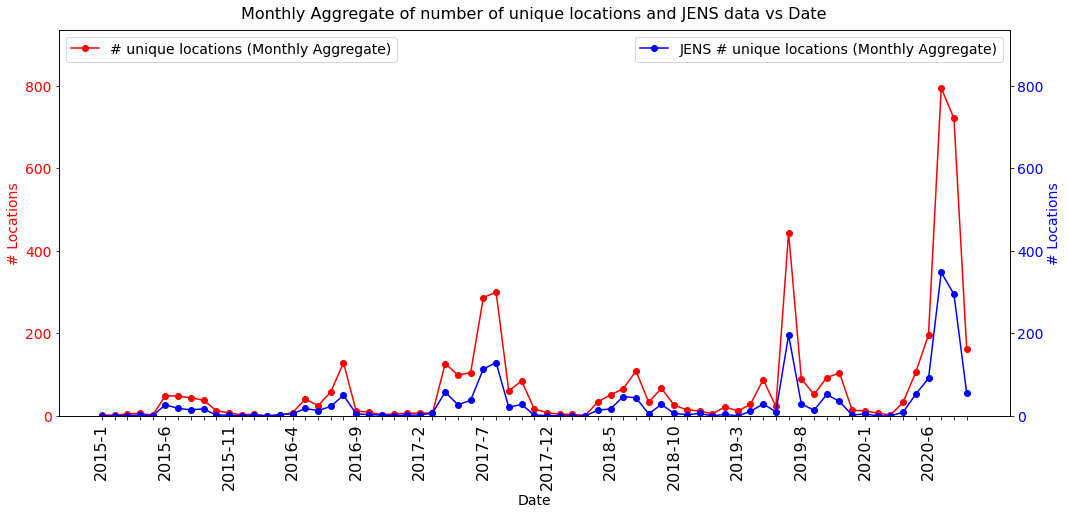

In [12]:
# datesLocationList = sorted([(k,v) for k,v in datesLocation.items()],
#                           key=lambda x:(tuple(map(int, x[0].split('-')))))        
# datesLocationList2 = complete_day_loc(datesLocationList, year_range=[2015, None], aggType='month')

# jensDatesLocationList = sorted([(k,v) for k,v in datesLocation_jens.items()],
#                           key=lambda x:(tuple(map(int, x[0].split('-')))))  
# jensDatesLocationList2 = complete_day_loc(jensDatesLocationList, year_range=[2015, None], aggType='month')

# plot_2timeseries(
#             {'count_list': datesLocationList2, 'label':'# unique locations (Monthly Aggregate)', 
#              'color':'r', 'ylabel':'# Locations'},
#             {'count_list': jensDatesLocationList2, 'label':'JENS # unique locations (Monthly Aggregate)', 
#              'color': 'b', 'ylabel': '# Locations'},
#             'Monthly Aggregate of number of unique locations and JENS data vs Date', 'Date', 
#     True, skip=5, sameY=True)

In [106]:
datesLocationList = sorted([(k,v) for k,v in datesLocation.items()],
                          key=lambda x:(tuple(map(int, x[0].split('-')))))

datesLocationList22 = defaultdict(lambda: defaultdict(int))
years = ['2015', '2016', '2017', '2018', '2019', '2020']
for ymd,locs in datesLocationList:
    year, month, day = ymd.split('-')
    if year in years and month == '7':
        for loc in locs:
            datesLocationList22[year][loc.lower()] += 1

json.dump(datesLocationList22, open('datesLocationList.json','w'), indent=2)


In [16]:
# jensDatesLocationList_week = defaultdict(lambda: defaultdict(int))
# dateRanges = [range(1,9), range(9,17), range(17,25), range(25,32)]
# dateRangesNames = ['1-8', '9-16', '17-24', '25-31']
# for ymd,locs in jensDatesLocationList:
#     year, month, day = ymd.split('-')
#     if year == '2020' and month == '7':
#         key = None
#         for i,drange in enumerate(dateRanges):
#             if int(day) in drange: key = dateRangesNames[i]
#         if not key: raise Exception('Check date', ymd)
#         key = str(day)
#         for loc in locs:
#             jensDatesLocationList_week[key][loc.lower()] += 1
# jensDatesLocationList_week
# json.dump(jensDatesLocationList_week, open('jensDatesLocationList_week_2020-7-all.json','w'), indent=2)

In [14]:
# jensDatesLocationList = sorted([(k,v) for k,v in datesLocation_jens.items()],
#                           key=lambda x:(tuple(map(int, x[0].split('-')))))  

# jensDatesWeekList = defaultdict(lambda: defaultdict(int))
# jensDatesLocationWorstWeek = defaultdict(lambda: [0]*8)
# start_date = '2020-07-01'
# end_date = '2020-08-26'
# weeks = 8
# dates = ['2020-07-{:02d}'.format(i) for i in range(1,32)] + ['2020-08-{:02d}'.format(i) for i in range(1,26)]
# dateRanges = [dates[i:i+7] for i in range(0,len(dates),7)]
# dateRangesNames = ['week-{}'.format(i+1) for i in range(len(dateRanges))]
# for ymd2,locs in jensDatesLocationList:
#     year, month, day = ymd2.split('-')
#     ymd = '{}-{:02d}-{:02d}'.format(year, int(month), int(day))
#     if year == '2020':
#         key, pos = None, None
#         for i,drange in enumerate(dateRanges):
#             if ymd in drange:
#                 pos = i
#                 key = dateRangesNames[i]
#                 break
#         if key:
#             for loc in locs:
#                 jensDatesWeekList[key][loc.lower()] += 1
#                 jensDatesLocationWorstWeek[loc.lower()][pos] += 1
# worstWeekLocation = {}
# michelleLocations = [i.split(',')[0].lower() for i in list(open('other_data/WeekSpearmansRanking.csv'))[1:]]
# michelle_me_map = {
#     'bogra': 'bogura',
#     'chapai nababganj': 'chapainawabganj',
#     'kishoregonj':'kishoreganj',
#     'netrakona':'netrokona',
#     'maulvibazar': 'moulvibazar'
# }
# for loc,weekList in jensDatesLocationWorstWeek.items():
#     weekList2 = sorted([(val,i+1) for i,val in enumerate(weekList)], reverse=True)
#     weeksOrdering = [i[1] for i in weekList2]
#     worstWeekLocation[michelle_me_map.get(loc,loc)] = weeksOrdering
# # print(worstWeekLocation)
# st = ['F{}'.format(i+1) for i in range(len(dateRanges))]
# st += ['rmse','spearman']
# toWrite = [f.strip() for f in list(open('other_data/WeekSpearmansRanking.csv'))]
# fullWrite, districtsCovered = [toWrite[0] + ',' + ','.join(st)], set()
# mLen = len(toWrite[0].split(','))
# newWrite = [toWrite[0] + ',' + ','.join(st)]
# rmseArr = []
# for i in range(1,len(toWrite)):
#     dist = toWrite[i].split(',')[0].lower()
#     michelleInt = [int(v) for v in toWrite[i].split(',')[2:]]
#     ordering = worstWeekLocation.get(dist,None)
#     districtsCovered.add(dist)
#     if ordering:
#         newSt = toWrite[i]
#         rmse = (sum([(michelleInt[v]-ordering[v])**2 for v in range(len(michelleInt))])/len(st))**(0.5)
#         spearman = 6*sum([(michelleInt[v]-ordering[v])**2 for v in range(len(michelleInt))])/(len(michelleInt)*(len(michelleInt)**2-1))
#         spearman = 1-spearman
#         rmseArr.append(rmse)
#         ordering = [str(o) for o in ordering]
#         newSt += ',' + ','.join(ordering)
#         fullWrite.append(newSt)
#         newSt += ',{:.2f}'.format(rmse) + ',{:.2f}'.format(spearman)
#         newWrite.append(newSt)
#     else:
#         newSt = toWrite[i]
#         ordering = ['']*(len(st)-1)
#         newSt += ',' + ','.join(ordering)
#         fullWrite.append(newSt)
# for dist in worstWeekLocation:
#     if dist not in districtsCovered:
#         ordering = worstWeekLocation.get(dist,None)
#         ordering = [str(o) for o in ordering]
#         newSt = dist.capitalize() + ',' + ','.join(['']*(mLen-1)) + ',' + ','.join(ordering)
#         fullWrite.append(newSt)
# open('other_data/WeekSpearmansRanking_flood.csv','w').write('\n'.join(newWrite))
# open('other_data/spearmen_floodONLY.csv','w').write('\n'.join(fullWrite))
# print(sum(rmseArr)/len(rmseArr))
# # json.dump(jensDatesLocationList_week2, open('jensDatesLocationList_week_2020-7-all.json','w'), indent=2)

2.7192536503618934


## Unique location

In [22]:
# def uniqueLoc(datesLocation, articleDates, aggType='fortnight', skip=5, year_range=[2015, None]):
#     datesLocationList = sorted([(k,v) for k,v in datesLocation.items()],
#                           key=lambda x:(tuple(map(int, x[0].split('-')))))
#     datesLocationList2 = complete_day_loc(datesLocationList, year_range=year_range, 
#                                           aggType=aggType, onlyUnique=True)
#     articleDatesList = complete_day([(k,v) for k,v in articleDates.items()], year_range=year_range, 
#                                     aggType=aggType)

#     plot_2timeseries(
#                 {'count_list': articleDatesList, 'label':'total flood articles per',
#                  'color': 'b', 'ylabel': '# flood articles'},
#                 {'count_list': datesLocationList2, 'label':'# unique locations (fortnight)', 
#                  'color':'r', 'ylabel':'# Locations'},
#                 'Number of unique locations per fortnight and total flood articles vs Date', 'Date', 
#         True, skip=5)
    

### Fortnightly unique location

<Figure size 1080x504 with 0 Axes>

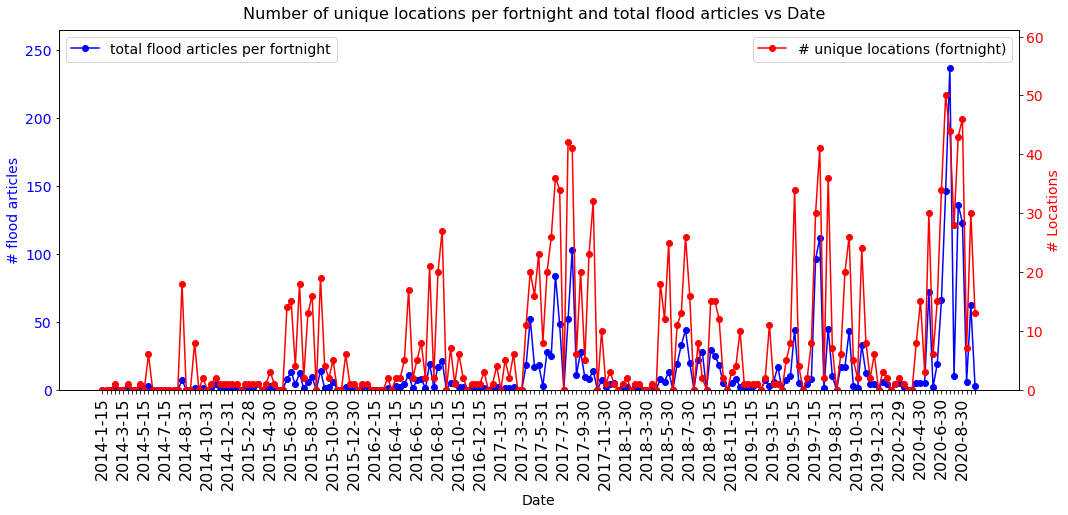

In [23]:
# datesLocationList = sorted([(k,v) for k,v in datesLocation.items()],
#                           key=lambda x:(tuple(map(int, x[0].split('-')))))
# datesLocationList2 = complete_day_loc(datesLocationList, year_range=[2014, None], 
#                                       aggType='fortnight', onlyUnique=True)
# articleDatesList = complete_day([(k,v) for k,v in articleDates.items()], year_range=[2014,None], aggType='fortnight')

# plot_2timeseries(
#             {'count_list': articleDatesList, 'label':'total flood articles per fortnight', 
#              'color': 'b', 'ylabel': '# flood articles'},
#             {'count_list': datesLocationList2, 'label':'# unique locations (fortnight)', 
#              'color':'r', 'ylabel':'# Locations'},
#             'Number of unique locations per fortnight and total flood articles vs Date', 'Date', 
#     True, skip=5)

# # plot_timeseries([
# #         {'count_list': datesLocationList2, 'label':'Number of Unique locations'},
# #     ], 'Unique Aggregate Fortnightly - Number of Unique locations vs Date', 'Date', '# Locations', True, skip=5)

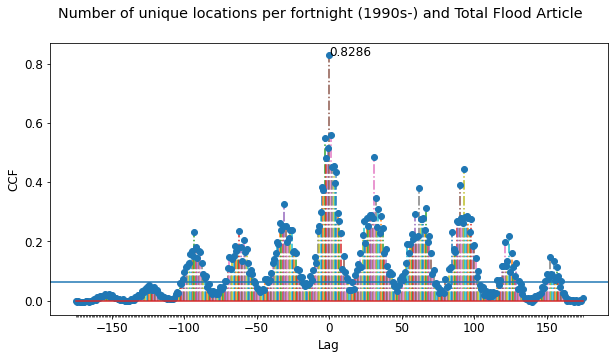

In [24]:
# datesLocationList = sorted([(k,v) for k,v in datesLocation.items()],
#                           key=lambda x:(tuple(map(int, x[0].split('-')))))
# datesLocationList2 = complete_day_loc(datesLocationList, year_range=[1990, None], 
#                                       aggType='fortnight', onlyUnique=True)
# articleDatesList = complete_day([(k,v) for k,v in articleDates.items()], year_range=[1990,None], aggType='fortnight')

# ccf(articleDatesList, datesLocationList2, tupList=True, plot=True,
#     title='Number of unique locations per fortnight (1990s-) and Total Flood Article', lag_max=175)


### Monthly unique location

<Figure size 1080x504 with 0 Axes>

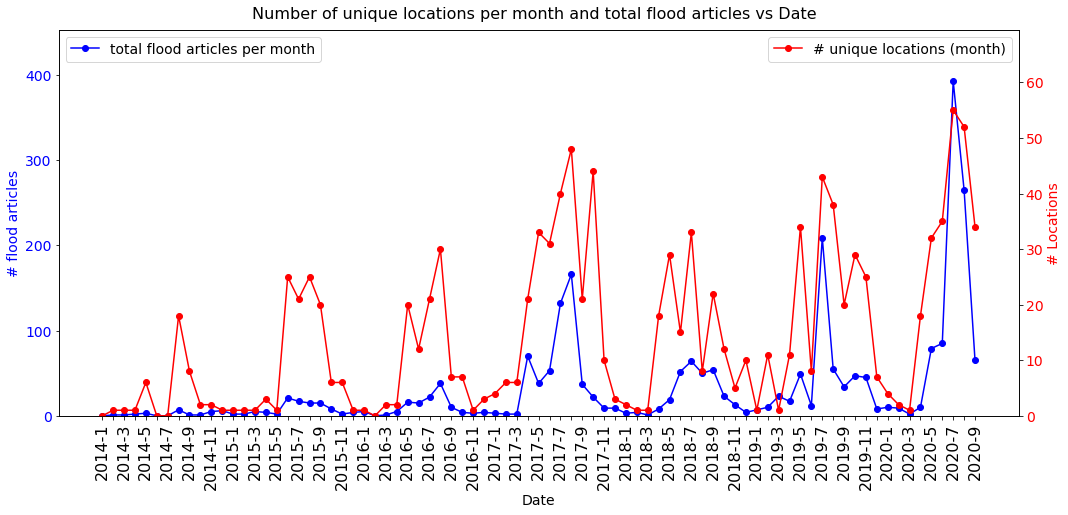

In [25]:
# datesLocationList = sorted([(k,v) for k,v in datesLocation.items()],
#                           key=lambda x:(tuple(map(int, x[0].split('-')))))
# datesLocationList2 = complete_day_loc(datesLocationList, year_range=[2014, None], 
#                                       aggType='month', onlyUnique=True)
# articleDatesList = complete_day([(k,v) for k,v in articleDates.items()], year_range=[2014,None], aggType='month')

# plot_2timeseries(
#             {'count_list': articleDatesList, 'label':'total flood articles per month', 
#              'color': 'b', 'ylabel': '# flood articles'},
#             {'count_list': datesLocationList2, 'label':'# unique locations (month)', 
#              'color':'r', 'ylabel':'# Locations'},
#             'Number of unique locations per month and total flood articles vs Date', 'Date', 
#     True, skip=2)

# # plot_timeseries([
# #         {'count_list': datesLocationList2, 'label':'Number of Unique locations'},
# #     ], 'Unique Aggregate Monthly - Number of Unique locations vs Date', 'Date', '# Locations', True)

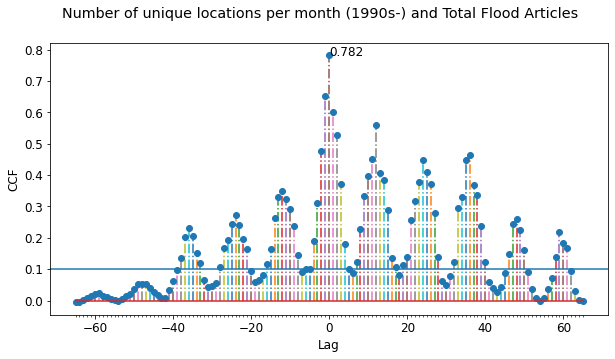

In [26]:
# datesLocationList = sorted([(k,v) for k,v in datesLocation.items()],
#                           key=lambda x:(tuple(map(int, x[0].split('-')))))
# datesLocationList2 = complete_day_loc(datesLocationList, year_range=[1990, None], 
#                                       aggType='month', onlyUnique=True)
# articleDatesList = complete_day([(k,v) for k,v in articleDates.items()], year_range=[1990,None], aggType='month')

# ccf(articleDatesList, datesLocationList2, tupList=True, plot=True,
#     title='Number of unique locations per month (1990s-) and Total Flood Articles', lag_max=65)

<Figure size 1080x504 with 0 Axes>

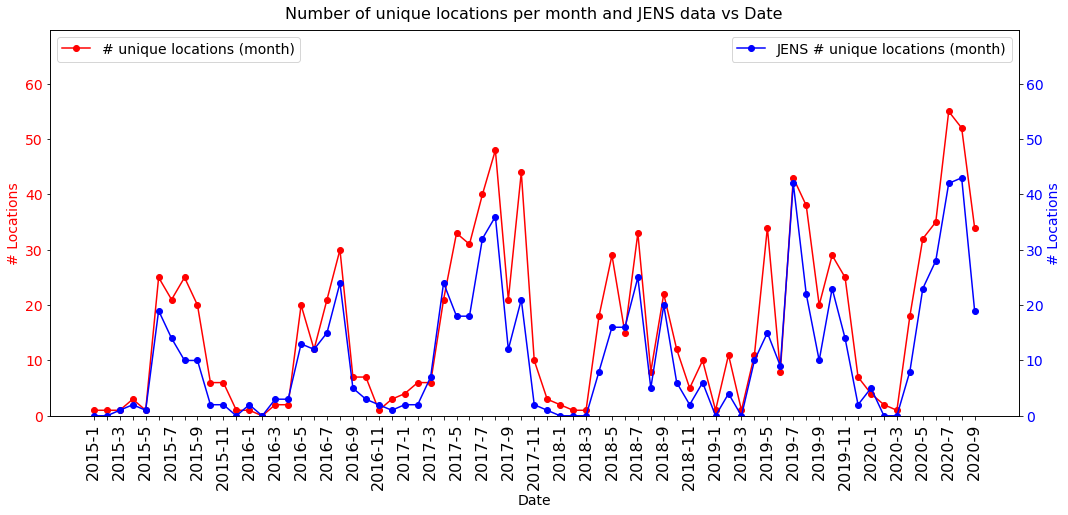

In [18]:
# datesLocationList = sorted([(k,v) for k,v in datesLocation.items()],
#                           key=lambda x:(tuple(map(int, x[0].split('-')))))
# datesLocationList2 = complete_day_loc(datesLocationList, year_range=[2015, None], 
#                                       aggType='month', onlyUnique=True)
# jensDatesLocationList = sorted([(k,v) for k,v in datesLocation_jens.items()],
#                           key=lambda x:(tuple(map(int, x[0].split('-')))))  
# jensDatesLocationList2 = complete_day_loc(jensDatesLocationList, year_range=[2015, None], 
#                                           aggType='month', onlyUnique=True)

# plot_2timeseries(
#             {'count_list': datesLocationList2, 'label':'# unique locations (month)', 
#              'color':'r', 'ylabel':'# Locations'},
#             {'count_list': jensDatesLocationList2, 'label':'JENS # unique locations (month)', 
#              'color': 'b', 'ylabel': '# Locations'},
#             'Number of unique locations per month and JENS data vs Date', 'Date', 
#     True, skip=2, sameY=True)

In [105]:
datesLocationList = sorted([(k,v) for k,v in datesLocation.items()],
                          key=lambda x:(tuple(map(int, x[0].split('-')))))
_,datesLocationList2 = complete_day_loc(datesLocationList, year_range=[2015, None], 
                                      aggType='month', onlyUnique=True, returnLoc=True)
datesLocationList2 = [(k,list(v)) for k,v in datesLocationList2 if '-7' in k]
json.dump(datesLocationList2, open('datesLocationList.json','w'), indent=2)

## Common Term Denormalization

In [24]:
siteCounts = json.load(open('siteCounts.json'))
dateCounts = defaultdict(int)
paperCounts = defaultdict(lambda: defaultdict(int))
for paper_name, paperEntry in siteCounts.items():
    for entry in paperEntry:
        sp = entry['date_range'] if type(entry['date_range'])!=list else entry['date_range'][0]
        month, day, year = sp.split('/')[:]
        diffFormatDate = '{}-{}-{}'.format(year, month, day)
        dateCounts[diffFormatDate]+=entry['site_count']
        paperCounts[paper_name][diffFormatDate]+=entry['site_count']

In [25]:
paperDist = {k:defaultdict(int) for k in range(2014, 2021)}
for paper_name, paperEntry in siteCounts.items():
    for entry in paperEntry:
        for date in paperDist:
            if str(date) in entry['date_range']: paperDist[date][paper_name] += entry['site_count']
paperDist

{2014: defaultdict(int,
             {'theDailyStar': 7,
              'theNewNation': 22,
              'bdnews': 45,
              'dailyObserver': 17,
              'dailySun': 2,
              'newAge': 0,
              'prothomalo': 0}),
 2015: defaultdict(int,
             {'theDailyStar': 61,
              'theNewNation': 29,
              'bdnews': 93,
              'dailyObserver': 29,
              'dailySun': 18,
              'newAge': 0,
              'prothomalo': 0}),
 2016: defaultdict(int,
             {'theIndependent': 2,
              'theDailyStar': 110,
              'theNewNation': 37,
              'bdnews': 148,
              'dailyObserver': 27,
              'dailySun': 33,
              'dhakaTribune': 1,
              'newAge': 8,
              'prothomalo': 1}),
 2017: defaultdict(int,
             {'theDailyStar': 136,
              'theNewNation': 58,
              'bdnews': 152,
              'dailyObserver': 24,
              'dailySun': 97,
          

In [26]:
sum([v for k,v in dateCounts.items() if '2014' in k]), \
sum([v for k,v in dateCounts.items() if '2015' in k]), \
sum([v for k,v in dateCounts.items() if '2016' in k]), \
sum([v for k,v in dateCounts.items() if '2017' in k]), \
sum([v for k,v in dateCounts.items() if '2018' in k]), \
sum([v for k,v in dateCounts.items() if '2019' in k]), \
sum([v for k,v in dateCounts.items() if '2020' in k])

(6734, 17355, 27639, 40408, 48994, 62169, 55383)

#### month

In [27]:
def plot_timeseries(l, title='', xlabel='', ylabel='', xticks_rotate=False, skip=0):
    plt.figure(figsize=(15, 7))
    colors = ['b', 'r', 'g', 'o']
    for i, entry in enumerate(l):
        plot_color = entry.get('color', colors[i])
        if entry.get('type', None) == 'bar':
            plt.bar([i[0] for i in entry['count_list']], [i[1] for i in entry['count_list']],
                    color=plot_color, label=entry['label'])
        else:
            plt.plot([i[0] for i in entry['count_list']], [i[1] for i in entry['count_list']],
                     linestyle='-', marker='o', color=plot_color, label=entry['label'])
        plt.xticks([i[0] for i in entry['count_list']])

#     plt.legend(fontsize=18)
    plt.title(title, fontsize=24)
    plt.xlabel(xlabel, fontsize=22)
    plt.ylabel(ylabel, fontsize=22)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    if xticks_rotate: plt.xticks(rotation='vertical')

    if skip:
        ax = plt.gca()
        temp = ax.xaxis.get_ticklabels()
        temp = list(set(temp) - set(temp[::skip]))
        for label in temp:
            label.set_visible(False)
    plt.show()

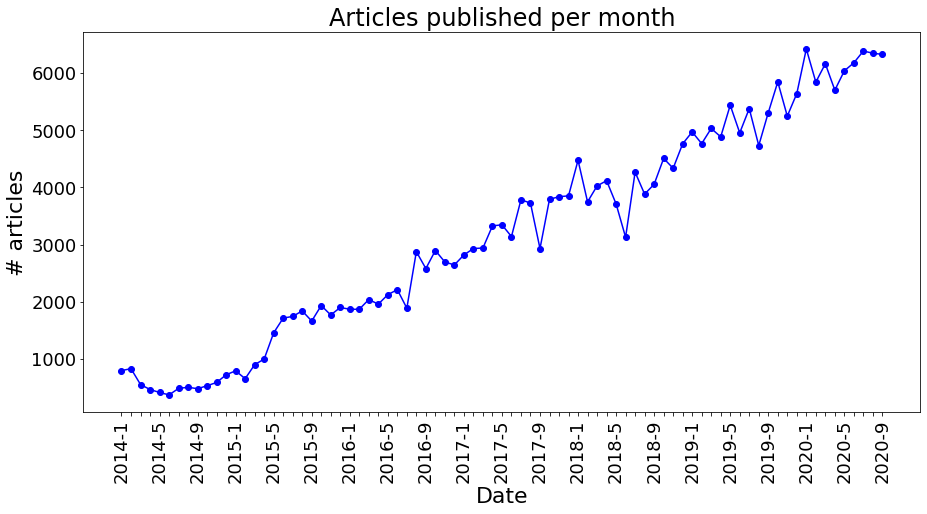

In [28]:
aggNorm = complete_day([(k,v) for k,v in dateCounts.items()], year_range=[2014,2020], 
                      aggType='month')
plot_timeseries([
        {'count_list': aggNorm, 'label':''},
    ], 'Articles published per month', 'Date', '# articles', True, skip=4)

### Normalized

#### Monthly, norm='monthly'

<Figure size 1080x504 with 0 Axes>

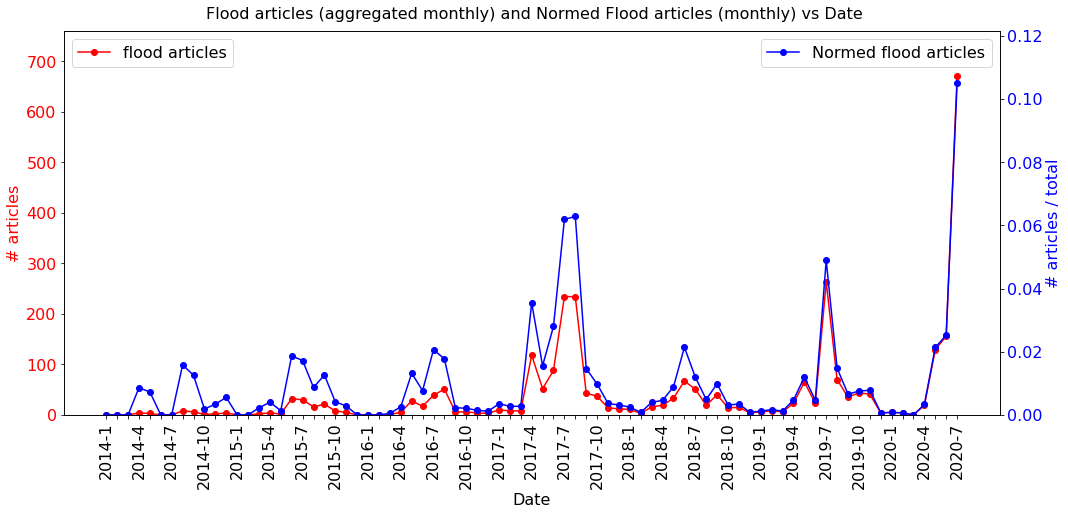

In [29]:
aggDayPrev = complete_day([(k,v) for k,v in articleDates.items()], year_range=[2014,2020], 
                      aggType='month', ignoreDates={2020:[8,9]})
aggDay = complete_day([(k,v) for k,v in articleDates.items()], year_range=[2014,2020], 
                      aggType='month', normDict=dateCounts, normAgg='month', ignoreDates={2020:[8,9]})

plot_2timeseries(
            {'count_list': aggDayPrev, 'label':'flood articles', 
             'color':'r', 'ylabel':'# articles'},
            {'count_list': aggDay, 'label':'Normed flood articles', 
             'color': 'b', 'ylabel': '# articles / total'},
            'Flood articles (aggregated monthly) and Normed Flood articles (monthly) vs Date', 'Date', True, skip=3)


In [30]:
ccf(aggDayPrev, aggDay, tupList=True, plot=True,
    title='Flood articles (aggregated monthly) and Normed Flood articles (monthly)', lag_max=40)

Spearmen Corr, pval: 0.8966, p-val=5.826008514665428e-29, n=79
Pearson Corr, pval: 0.9465, p-val=1.3967496785339512e-39, n=79


((0.8966, 5.826008514665428e-29, 79), (0.9465, 1.3967496785339512e-39, 79))

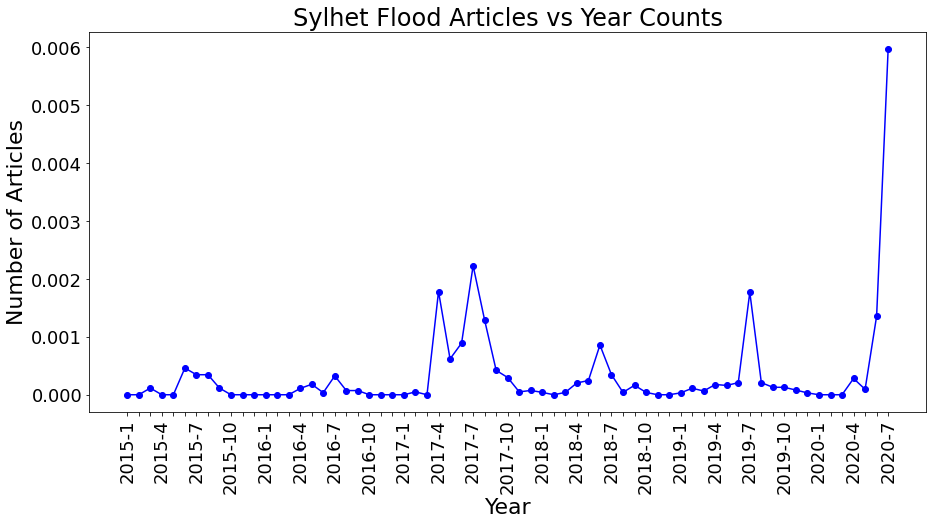

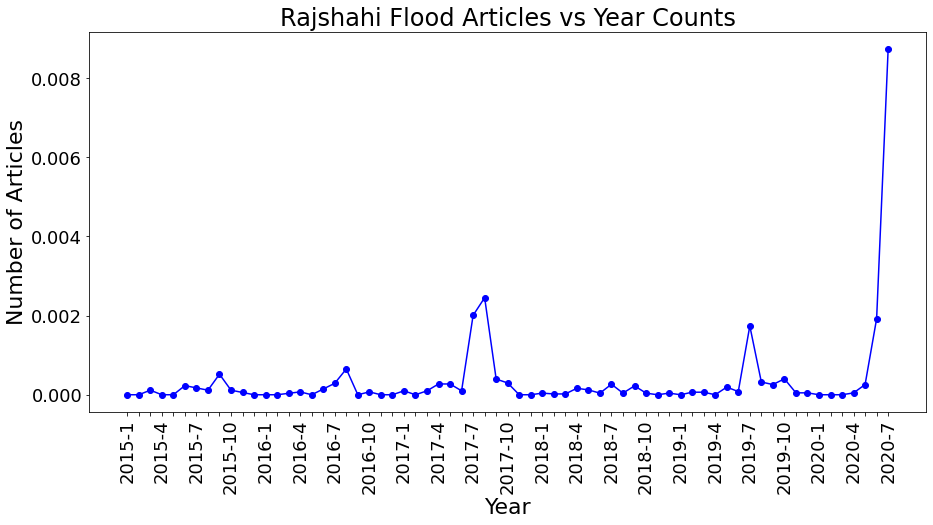

In [31]:
aggDaySylhet = complete_day([(k,v) for k,v in articleDatesSylhet.items()], year_range=[2015,2020], 
                      aggType='month', normDict=dateCounts, normAgg='year', ignoreDates={2020:[8,9]})
aggDayRajshahi = complete_day([(k,v) for k,v in articleDatesRajshahi.items()], year_range=[2015,2020], 
                      aggType='month', normDict=dateCounts, normAgg='year', ignoreDates={2020:[8,9]})
# plot_2timeseries(
#             {'count_list': aggDaySylhet, 'label':'Slyhet', 
#              'color':'b', 'ylabel':'Number of Articles'},
#             {'count_list': aggDay, 'label':'Normed flood articles', 
#              'color': 'g', 'ylabel': 'Number of Articles'},
#             'Sylhet and Rajshahi Flood articles vs Date', 'Date', True, skip=3, sameY=True)


plot_timeseries([
            {'count_list': aggDaySylhet, 'label':''},
        ], 'Sylhet Flood Articles vs Year Counts', 'Year', 'Number of Articles', True, skip=3)
plot_timeseries([
            {'count_list': aggDayRajshahi, 'label':''},
        ], 'Rajshahi Flood Articles vs Year Counts', 'Year', 'Number of Articles', True, skip=3)

#### Monthly, Norm='yearly'

<Figure size 1080x504 with 0 Axes>

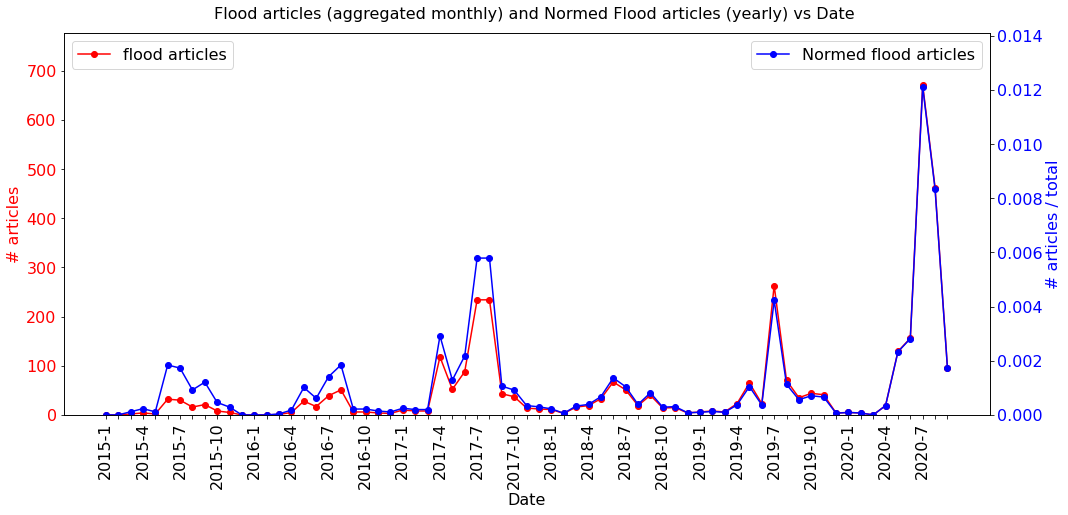

In [32]:
aggDayPrev = complete_day([(k,v) for k,v in articleDates.items()], year_range=[2015,2020], 
                      aggType='month')
aggDay = complete_day([(k,v) for k,v in articleDates.items()], year_range=[2015,2020], 
                      aggType='month', normDict=dateCounts, normAgg='year')

plot_2timeseries(
            {'count_list': aggDayPrev, 'label':'flood articles', 
             'color':'r', 'ylabel':'# articles'},
            {'count_list': aggDay, 'label':'Normed flood articles', 
             'color': 'b', 'ylabel': '# articles / total'},
            'Flood articles (aggregated monthly) and Normed Flood articles (yearly) vs Date', 'Date', True, skip=3)


In [33]:
ccf(aggDayPrev, aggDay, tupList=True, plot=True,
    title='Flood articles (aggregated monthly) and Normed Flood articles (yearly)', lag_max=40)

Spearmen Corr, pval: 0.9576, p-val=6.134313841726569e-38, n=69
Pearson Corr, pval: 0.9815, p-val=8.07226981150134e-50, n=69


((0.9576, 6.134313841726569e-38, 69), (0.9815, 8.07226981150134e-50, 69))

EM-DAT

<Figure size 1080x504 with 0 Axes>

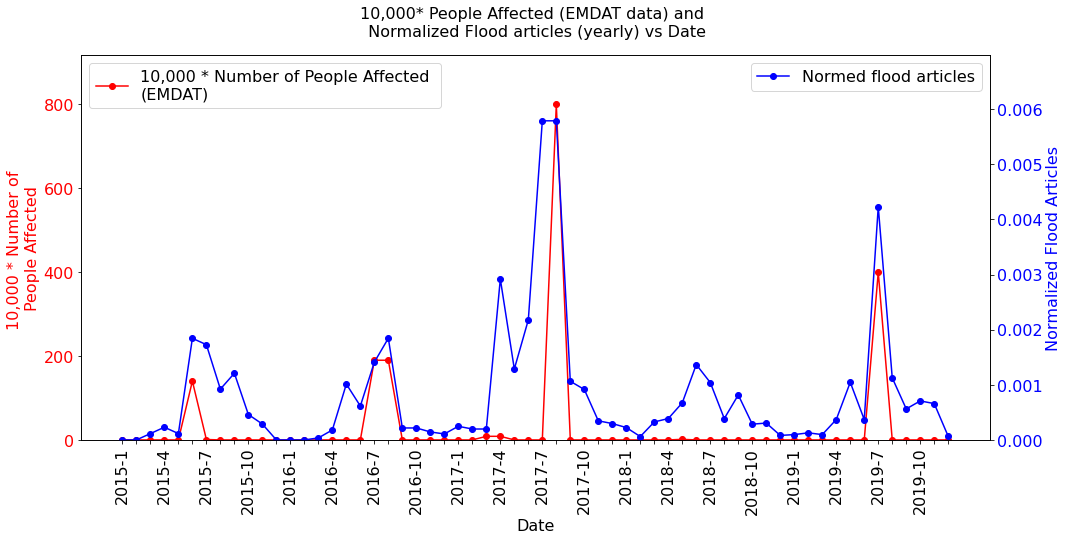

In [34]:
emdat_df = pd.read_csv('other_data/emdat_flood.csv').drop('Unnamed: 0', axis=1).fillna(0)
year_month = []
for row in emdat_df.iterrows():
    if int(row[1]['Start Month']):
        year_month.append(('{}-{}'.format(int(row[1]['Start Year']), int(row[1]['Start Month'])), 
                           row[1]['Total Affected']/10000))
    if int(row[1]['End Month']):
        year_month.append(('{}-{}'.format(int(row[1]['End Year']), int(row[1]['End Month'])), 
                        row[1]['Total Affected']/10000))
# year_month = complete_day(year_month, year_range=[2017,2020], aggType='month', ignoreDates={2020:[8,9]})
aggDay = complete_day([(k,v) for k,v in articleDates.items()], year_range=[2015,2019], 
                      aggType='month', normDict=dateCounts, normAgg='year')
aggDay, year_month = match_years_months(aggDay, year_month, [2015,2019])
plot_2timeseries(
            {'count_list': year_month, 'label':'10,000 * Number of People Affected \n(EMDAT)', 
             'color':'r', 'ylabel':'10,000 * Number of \nPeople Affected'},
            {'count_list': aggDay, 'label':'Normed flood articles', 
             'color': 'b', 'ylabel': 'Normalized Flood Articles'},
            '10,000* People Affected (EMDAT data) and \n Normalized Flood articles (yearly) vs Date', 'Date', True, skip=3)


In [35]:
ccf(year_month, aggDay, tupList=True, plot=True,
    title='10,000* People Affected (EMDAT data) and \n Normalized Flood articles (yearly)', lag_max=40)

Spearmen Corr, pval: 0.4721, p-val=0.0001400375824572237, n=60
Pearson Corr, pval: 0.6807, p-val=2.187180143257582e-09, n=60


((0.4721, 0.0001400375824572237, 60), (0.6807, 2.187180143257582e-09, 60))

Government Data

<Figure size 1080x504 with 0 Axes>

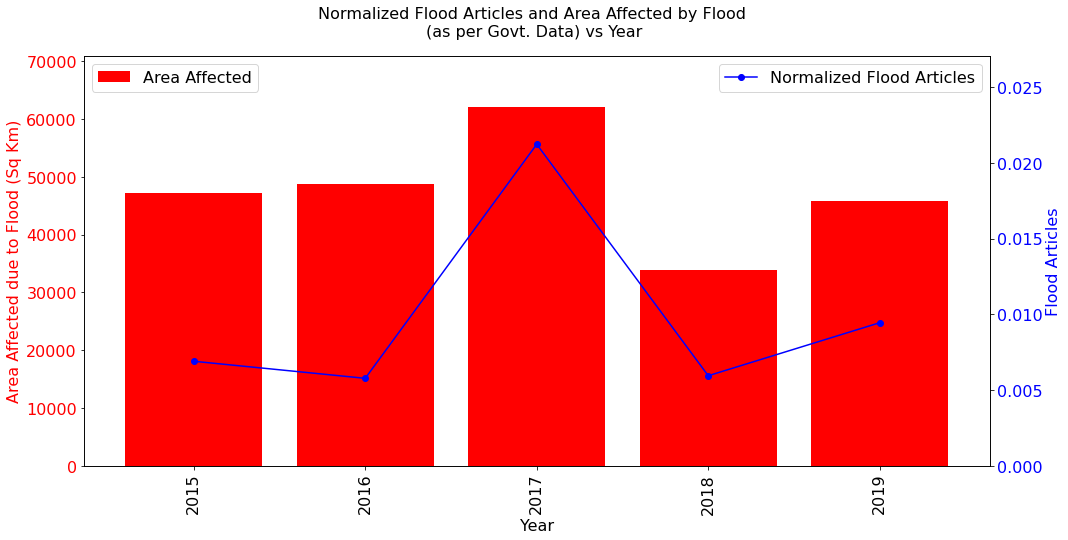

In [36]:
filepath = 'other_data/Flood_Affected_Area_Barchart.csv'
faf_df = pd.read_csv(filepath)

faf_year_flood_affected = [(row[1]['Year'], int(row[1]['Flood affected area'].replace(',',''))) 
                           for row in faf_df.iterrows()]
faf_year_flood_affected = [i for i in faf_year_flood_affected if int(i[0])>=2015 and int(i[0])<2020]

aggDay = complete_day([(k,v) for k,v in articleDates.items()], year_range=[2015,2019], 
                      aggType='year', normDict=dateCounts, normAgg='year', ignoreDates={2020:[8,9]})
aggDay = [(int(i),j) for i,j in aggDay]
aggDay, faf_year_flood_affected = match_years(aggDay, faf_year_flood_affected)

plot_2timeseries(
            {'count_list': faf_year_flood_affected, 'label':'Area Affected', 
             'type': 'bar', 'color':'r', 'ylabel':'Area Affected due to Flood (Sq Km)', 'ylim_min':0},
            {'count_list': aggDay, 'label':'Normalized Flood Articles', 
             'color': 'b', 'ylabel': 'Flood Articles'},
            'Normalized Flood Articles and Area Affected by Flood \n(as per Govt. Data) vs Year', 
            'Year', True, xticksFontSize=14)

In [37]:
ccf(aggDay, faf_year_flood_affected, tupList=True, plot=True,
    title='Government Data and \n Normalized Flood articles (yearly)', lag_max=2)

Spearmen Corr, pval: 0.3, p-val=0.6238376647810728, n=5
Pearson Corr, pval: 0.8241, p-val=0.08616571781613339, n=5


((0.3, 0.6238376647810728, 5), (0.8241, 0.08616571781613339, 5))

Twitter All

<Figure size 1080x504 with 0 Axes>

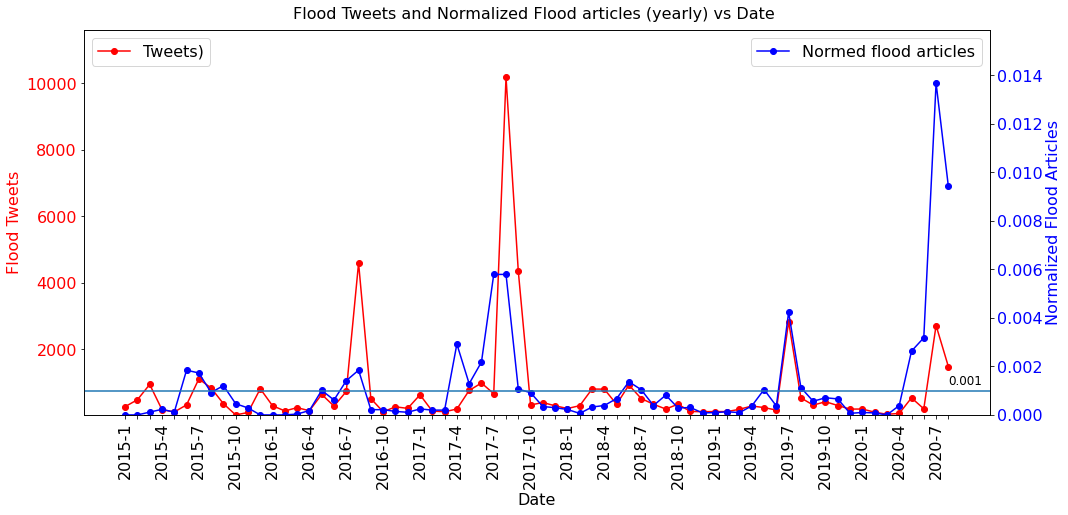

In [38]:
ignoreDates = {2020:[9,10,11,12]}
twitter_filepath = 'timeseries_data/twitter/TwitterAll.json'
twitterData = json.load(open(twitter_filepath))
twitterDataList = complete_day([(k,v) for k,v in twitterData.items()], aggType='month', 
                               year_range=[2015,2020], ignoreDates=ignoreDates)

aggDay = complete_day([(k,v) for k,v in articleDates.items()], year_range=[2015,2020], 
                      aggType='month', normDict=dateCounts, normAgg='year', ignoreDates=ignoreDates)
# aggDay, twitterDataList = match_years_months(aggDay, twitterDataList, [2015,2020])

plot_2timeseries(
            {'count_list': twitterDataList, 'label':'Tweets)', 
             'color':'r', 'ylabel':'Flood Tweets'},
            {'count_list': aggDay, 'label':'Normed flood articles', 
             'color': 'b', 'ylabel': 'Normalized Flood Articles'},
            'Flood Tweets and Normalized Flood articles (yearly) vs Date', 'Date', True, skip=3, yline=0.001)


In [39]:
ccf(aggDay, twitterDataList, tupList=True, plot=True,
    title='Twitter Data and \n Normalized Flood articles (yearly)', lag_max=50)

Spearmen Corr, pval: 0.5712, p-val=3.640994995919603e-07, n=68
Pearson Corr, pval: 0.4667, p-val=6.021506871714784e-05, n=68


((0.5712, 3.640994995919603e-07, 68), (0.4667, 6.021506871714784e-05, 68))

Twitter Sylhet

<Figure size 1080x504 with 0 Axes>

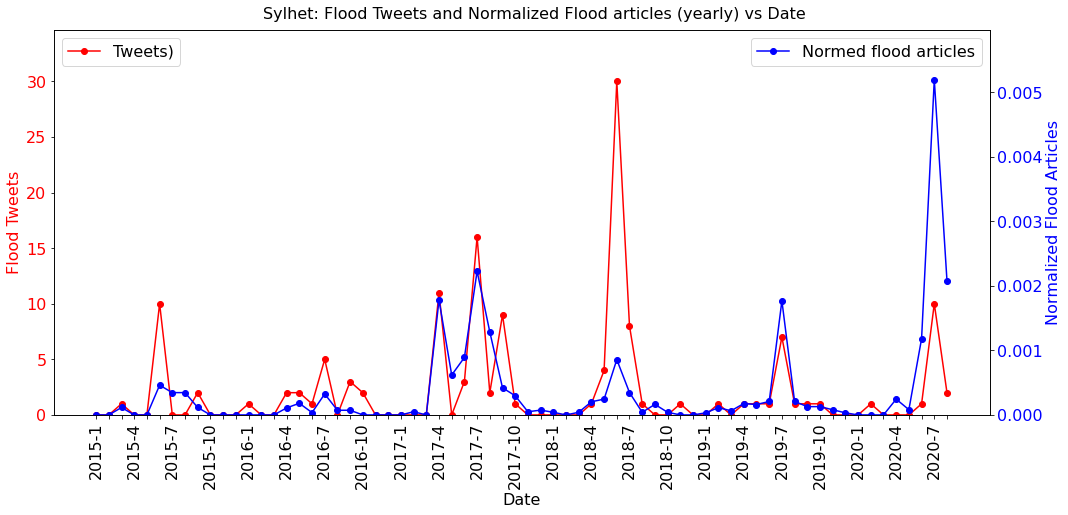

In [40]:
ignoreDates = {2020:[9,10,11,12]}
twitter_filepath = 'timeseries_data/twitter/TwitterSylhet.json'
twitterData = json.load(open(twitter_filepath))
twitterDataList = complete_day([(k,v) for k,v in twitterData.items()], aggType='month', 
                               year_range=[2015,2020], ignoreDates=ignoreDates)

aggDay = complete_day([(k,v) for k,v in articleDatesSylhet.items()], year_range=[2015,2020], 
                      aggType='month', normDict=dateCounts, normAgg='year', ignoreDates=ignoreDates)

plot_2timeseries(
            {'count_list': twitterDataList, 'label':'Tweets)', 
             'color':'r', 'ylabel':'Flood Tweets'},
            {'count_list': aggDay, 'label':'Normed flood articles', 
             'color': 'b', 'ylabel': 'Normalized Flood Articles'},
            'Sylhet: Flood Tweets and Normalized Flood articles (yearly) vs Date', 'Date', True, skip=3)


In [41]:
ccf(aggDay, twitterDataList, tupList=True, plot=True,
    title='Twitter Data and \n Normalized Flood articles (yearly)', lag_max=40)

Spearmen Corr, pval: 0.6563, p-val=1.2357582849346993e-09, n=68
Pearson Corr, pval: 0.5005, p-val=1.3843954233701668e-05, n=68


((0.6563, 1.2357582849346993e-09, 68), (0.5005, 1.3843954233701668e-05, 68))

Twitter Rajshahi

<Figure size 1080x504 with 0 Axes>

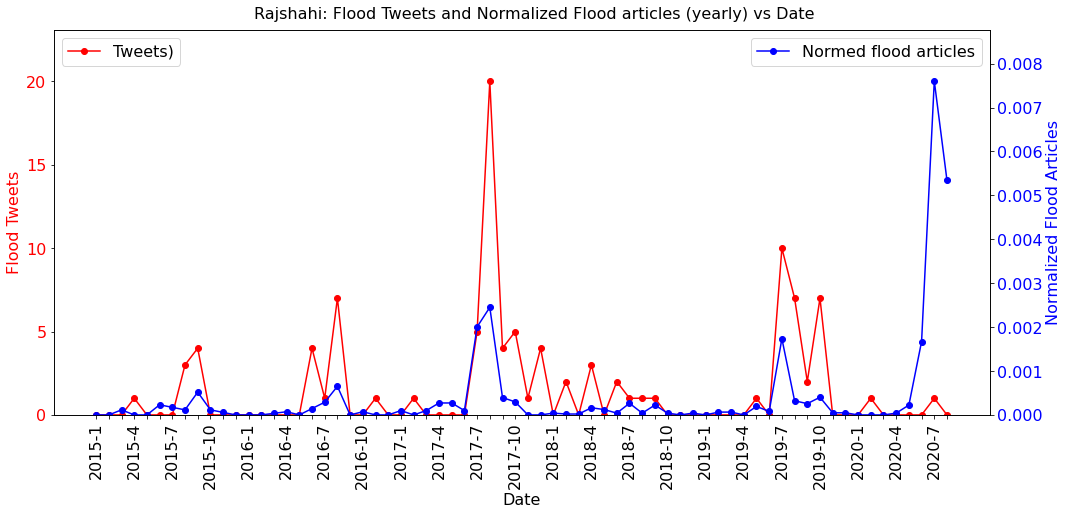

In [42]:
ignoreDates = {2020:[9,10,11,12]}
twitter_filepath = 'timeseries_data/twitter/TwitterRajshahi.json'
twitterData = json.load(open(twitter_filepath))
twitterDataList = complete_day([(k,v) for k,v in twitterData.items()], aggType='month', 
                               year_range=[2015,2020], ignoreDates=ignoreDates)

aggDay = complete_day([(k,v) for k,v in articleDatesRajshahi.items()], year_range=[2015,2020], 
                      aggType='month', normDict=dateCounts, normAgg='year', ignoreDates=ignoreDates)

plot_2timeseries(
            {'count_list': twitterDataList, 'label':'Tweets)', 
             'color':'r', 'ylabel':'Flood Tweets'},
            {'count_list': aggDay, 'label':'Normed flood articles', 
             'color': 'b', 'ylabel': 'Normalized Flood Articles'},
            'Rajshahi: Flood Tweets and Normalized Flood articles (yearly) vs Date', 'Date', True, skip=3)


In [43]:
ccf(aggDay, twitterDataList, tupList=True, plot=True,
    title='Twitter Data and \n Normalized Flood articles (yearly)', lag_max=40)

Spearmen Corr, pval: 0.429, p-val=0.0002620762173716246, n=68
Pearson Corr, pval: 0.2478, p-val=0.04163459970172368, n=68


((0.429, 0.0002620762173716246, 68), (0.2478, 0.04163459970172368, 68))

#### Sylhet monthly, norm = 'yearly'

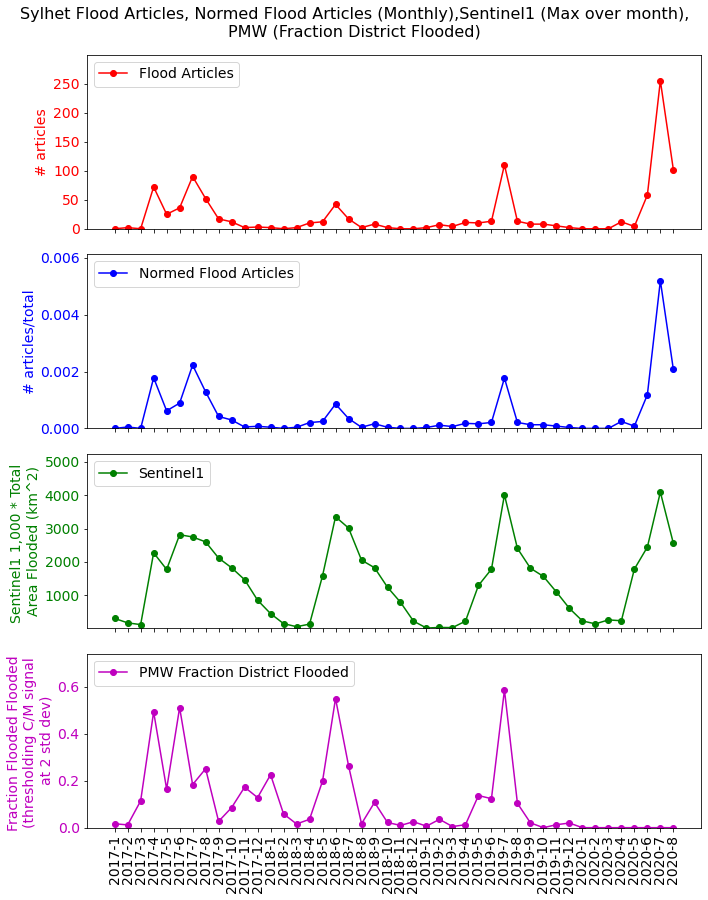

In [44]:
ignoreDates = {2020:[9,10,11,12]}
aggDayPrev = complete_day([(k,v) for k,v in articleDatesSylhet.items()], year_range=[2017,2020], 
                      aggType='month', ignoreDates=ignoreDates)
aggDay = complete_day([(k,v) for k,v in articleDatesSylhet.items()], year_range=[2017,2020], 
                      aggType='month', normDict=dateCounts, normAgg='year', ignoreDates=ignoreDates)
aggSentinel = get_Sentinel1_data_monthly('sylhet', ignoreDates=ignoreDates)
aggPMW = get_PMW_data_monthly('sylhet', ignoreDates=ignoreDates)

subPlotN(
            [{'count_list': aggDayPrev, 'label':'Flood Articles',
             'color': 'r', 'ylabel':'# articles'},
            {'count_list': aggDay, 'label':'Normed Flood Articles', 
             'color': 'b', 'ylabel': '# articles/total'},
            {'count_list': aggSentinel, 'label':'Sentinel1', 
             'color': 'g', 'ylabel': 'Sentinel1 1,000 * Total \nArea Flooded (km^2)'},
            {'count_list': aggPMW, 'label':'PMW Fraction District Flooded', 
             'color': 'm', 'ylabel': 'Fraction Flooded Flooded \n(thresholding C/M signal \nat 2 std dev)'}],
            'Sylhet Flood Articles, Normed Flood Articles (Monthly),Sentinel1 (Max over month),\nPMW (Fraction District Flooded)', 'Year-Month', True)


<Figure size 1080x504 with 0 Axes>

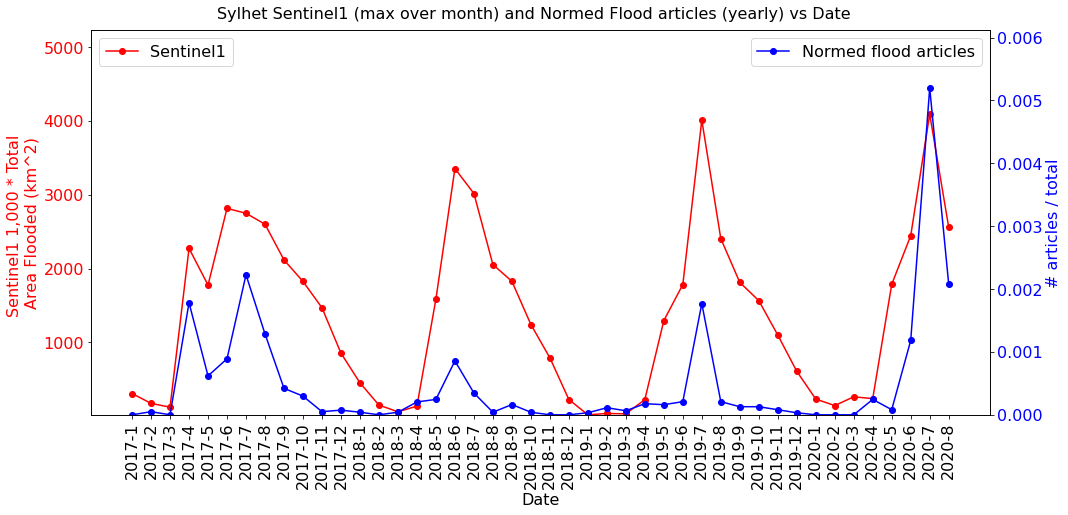

Spearmen Corr, pval: 0.7646, p-val=1.5324548415898584e-09, n=44
Pearson Corr, pval: 0.6913, p-val=2.0474125734287735e-07, n=44


((0.7646, 1.5324548415898584e-09, 44), (0.6913, 2.0474125734287735e-07, 44))

In [45]:
plot_2timeseries(
            {'count_list': aggSentinel, 'label':'Sentinel1', 
             'color':'r', 'ylabel':'Sentinel1 1,000 * Total \nArea Flooded (km^2)'},
            {'count_list': aggDay, 'label':'Normed flood articles', 
             'color': 'b', 'ylabel': '# articles / total'},
            'Sylhet Sentinel1 (max over month) and Normed Flood articles (yearly) vs Date', 'Date', True)
ccf(aggSentinel, aggDay, tupList=True, plot=True,
    title='Sylhet Sentinel1 (max over month) and Normed Flood articles (yearly)', lag_max=40)


<Figure size 1080x504 with 0 Axes>

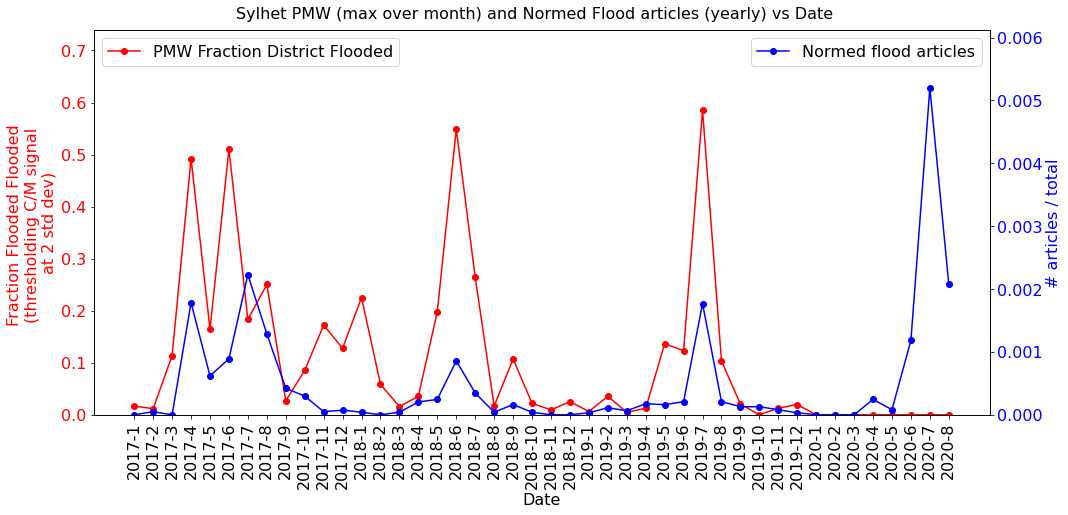

Spearmen Corr, pval: 0.3668, p-val=0.014330048602015477, n=44
Pearson Corr, pval: 0.263, p-val=0.08459017046147158, n=44


((0.3668, 0.014330048602015477, 44), (0.263, 0.08459017046147158, 44))

In [46]:
plot_2timeseries(
            {'count_list': aggPMW, 'label':'PMW Fraction District Flooded', 
             'color': 'r', 'ylabel': 'Fraction Flooded Flooded \n(thresholding C/M signal \nat 2 std dev)'},
            {'count_list': aggDay, 'label':'Normed flood articles', 
             'color': 'b', 'ylabel': '# articles / total'},
            'Sylhet PMW (max over month) and Normed Flood articles (yearly) vs Date', 'Date', True)
ccf(aggPMW, aggDay, tupList=True, plot=True,
    title='Sylhet PMW (max over month) and Normed Flood articles (yearly)', lag_max=40)


#### Rajshahi, norm=yearly

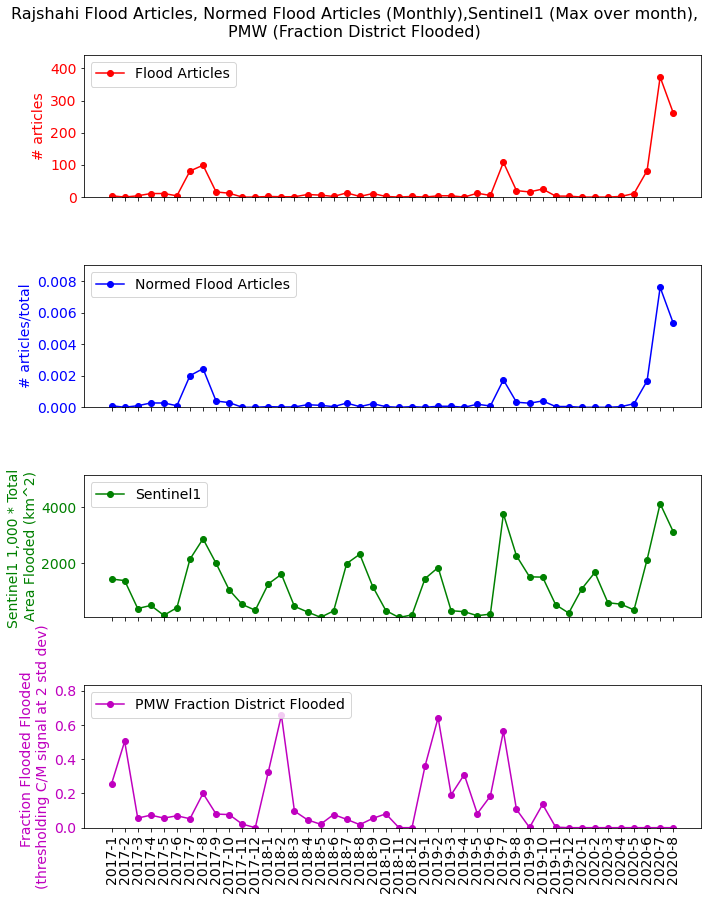

In [47]:
ignoreDates = {2020:[9,10,11,12]}
aggDayPrev = complete_day([(k,v) for k,v in articleDatesRajshahi.items()], year_range=[2017,2020], 
                      aggType='month', ignoreDates=ignoreDates)
aggDay = complete_day([(k,v) for k,v in articleDatesRajshahi.items()], year_range=[2017,2020], 
                      aggType='month', normDict=dateCounts, normAgg='year', ignoreDates=ignoreDates)
aggSentinel = get_Sentinel1_data_monthly('rajshahi', ignoreDates=ignoreDates)
aggPMW = get_PMW_data_monthly('rajshahi', ignoreDates=ignoreDates)

subPlotN(
            [{'count_list': aggDayPrev, 'label':'Flood Articles',
             'color': 'r', 'ylabel':'# articles'},
            {'count_list': aggDay, 'label':'Normed Flood Articles', 
             'color': 'b', 'ylabel': '# articles/total'},
            {'count_list': aggSentinel, 'label':'Sentinel1', 
             'color': 'g', 'ylabel': 'Sentinel1 1,000 * Total \nArea Flooded (km^2)'},
            {'count_list': aggPMW, 'label':'PMW Fraction District Flooded', 
             'color': 'm', 'ylabel': 'Fraction Flooded Flooded \n(thresholding C/M signal at 2 std dev)'}],
            'Rajshahi Flood Articles, Normed Flood Articles (Monthly),Sentinel1 (Max over month),\nPMW (Fraction District Flooded)', 'Year-Month', True)


<Figure size 1080x504 with 0 Axes>

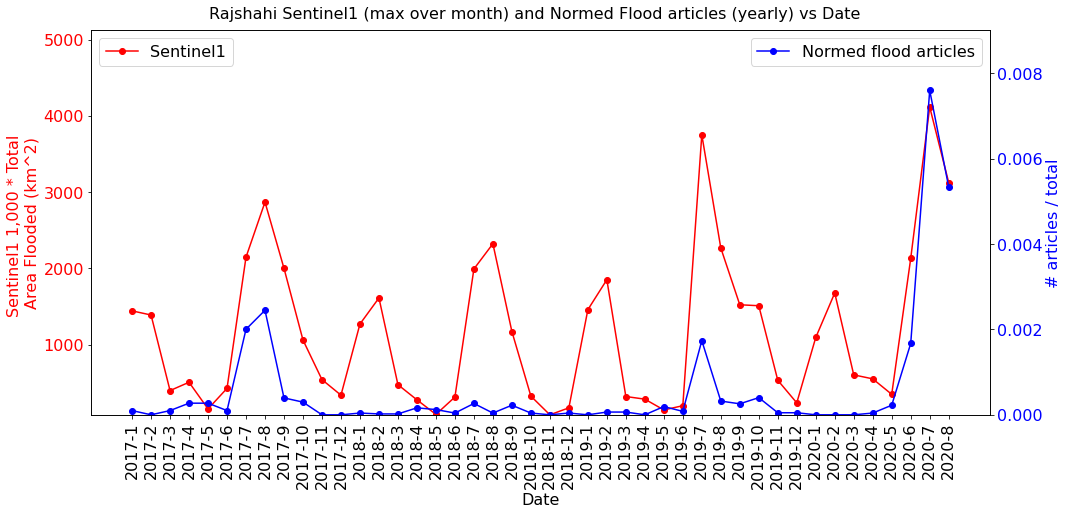

Spearmen Corr, pval: 0.4137, p-val=0.005244936966431279, n=44
Pearson Corr, pval: 0.7083, p-val=7.530907380896761e-08, n=44


((0.4137, 0.005244936966431279, 44), (0.7083, 7.530907380896761e-08, 44))

In [48]:
plot_2timeseries(
            {'count_list': aggSentinel, 'label':'Sentinel1', 
             'color':'r', 'ylabel':'Sentinel1 1,000 * Total \nArea Flooded (km^2)'},
            {'count_list': aggDay, 'label':'Normed flood articles', 
             'color': 'b', 'ylabel': '# articles / total'},
            'Rajshahi Sentinel1 (max over month) and Normed Flood articles (yearly) vs Date', 'Date', True)
ccf(aggSentinel, aggDay, tupList=True, plot=True,
    title='Rajshahi Sentinel1 (max over month) and Normed Flood articles (yearly)', lag_max=40)

<Figure size 1080x504 with 0 Axes>

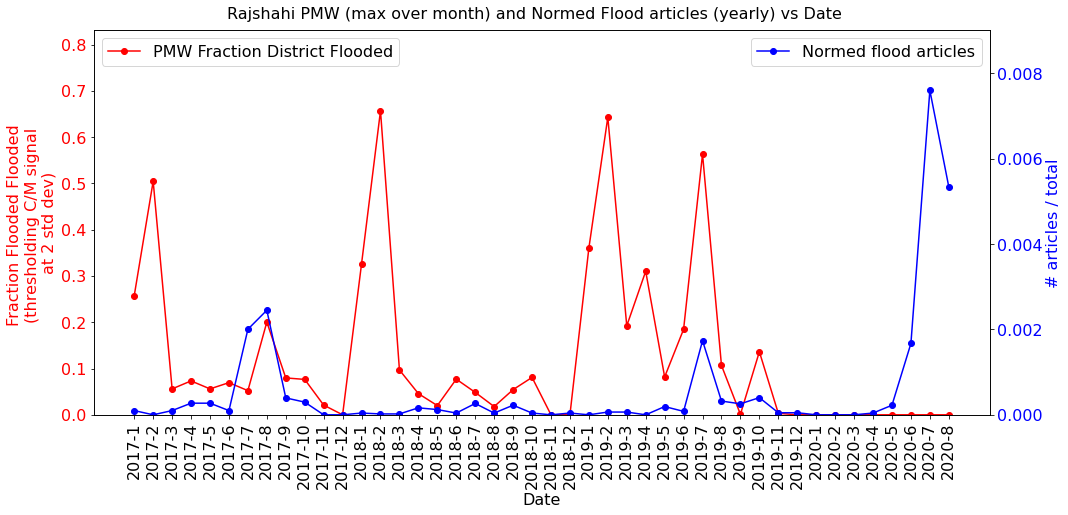

Spearmen Corr, pval: 0.0367, p-val=0.8129584896068835, n=44
Pearson Corr, pval: -0.1064, p-val=0.4916590295493898, n=44


((0.0367, 0.8129584896068835, 44), (-0.1064, 0.4916590295493898, 44))

In [49]:
plot_2timeseries(
            {'count_list': aggPMW, 'label':'PMW Fraction District Flooded', 
             'color': 'r', 'ylabel': 'Fraction Flooded Flooded \n(thresholding C/M signal \nat 2 std dev)'},
            {'count_list': aggDay, 'label':'Normed flood articles', 
             'color': 'b', 'ylabel': '# articles / total'},
            'Rajshahi PMW (max over month) and Normed Flood articles (yearly) vs Date', 'Date', True)
ccf(aggPMW, aggDay, tupList=True, plot=True,
    title='Rajshahi PMW (max over month) and Normed Flood articles (yearly)', lag_max=40)


### Twitter + Sentinel1

<Figure size 1080x504 with 0 Axes>

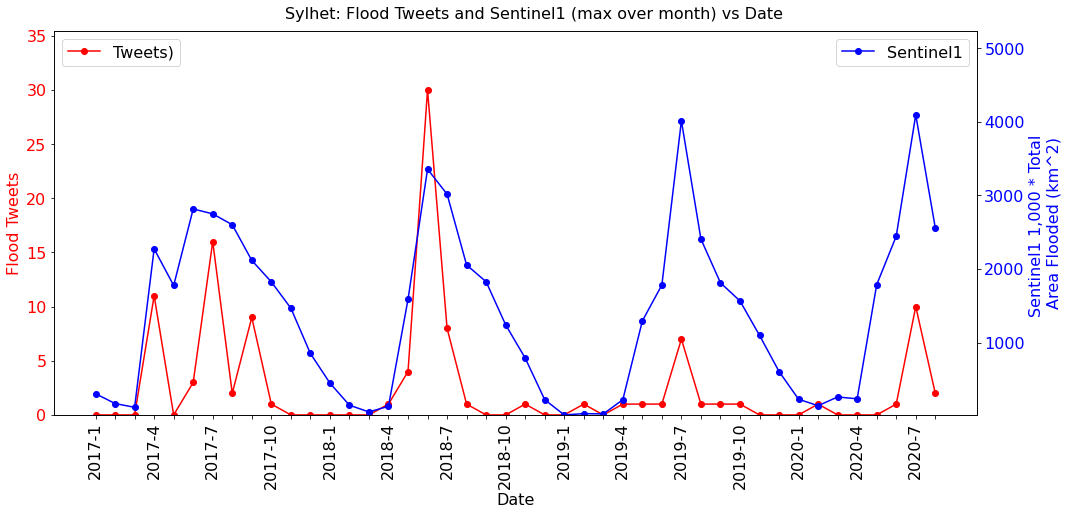

Spearmen Corr, pval: 0.6936, p-val=1.7906373958684195e-07, n=44
Pearson Corr, pval: 0.5995, p-val=1.706995317176447e-05, n=44


((0.6936, 1.7906373958684195e-07, 44), (0.5995, 1.706995317176447e-05, 44))

In [50]:
ignoreDates = {2020:[9,10,11,12]}
aggSentinel = get_Sentinel1_data_monthly('sylhet', ignoreDates=ignoreDates)
twitter_filepath = 'timeseries_data/twitter/TwitterSylhet.json'
twitterData = json.load(open(twitter_filepath))
twitterDataList = complete_day([(k,v) for k,v in twitterData.items()], aggType='month', 
                               year_range=[2017,2020], ignoreDates=ignoreDates)

plot_2timeseries(
            {'count_list': twitterDataList, 'label':'Tweets)', 
             'color':'r', 'ylabel':'Flood Tweets'},
            {'count_list': aggSentinel, 'label':'Sentinel1', 
             'color':'b', 'ylabel':'Sentinel1 1,000 * Total \nArea Flooded (km^2)'},
            'Sylhet: Flood Tweets and Sentinel1 (max over month) vs Date', 'Date', True, skip=3)

ccf(twitterDataList, aggSentinel, tupList=True, plot=True,
    title='Rajshahi PMW (max over month) and Normed Flood articles (yearly)', lag_max=40)

<Figure size 1080x504 with 0 Axes>

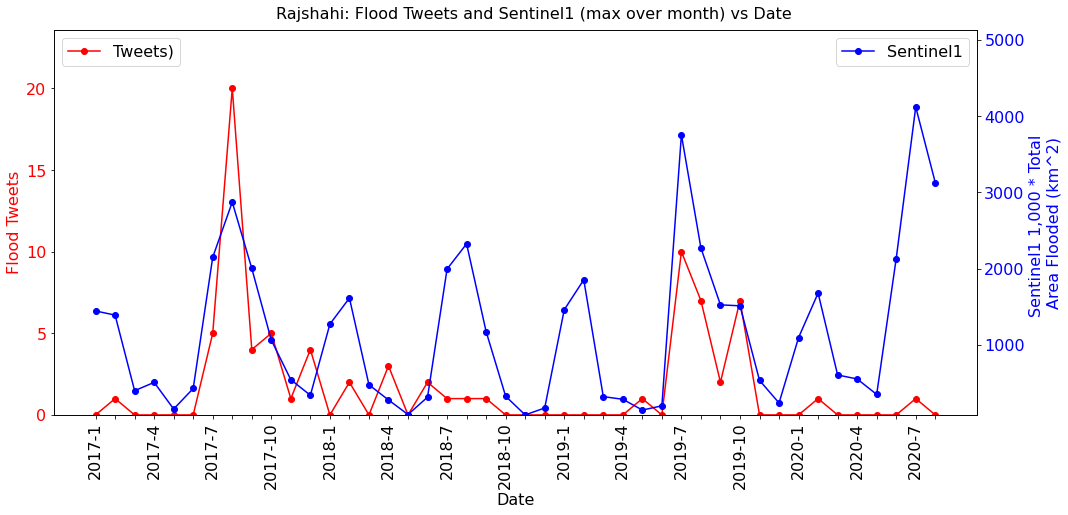

Spearmen Corr, pval: 0.4584, p-val=0.0017538602738872953, n=44
Pearson Corr, pval: 0.4753, p-val=0.0011132803590003, n=44


((0.4584, 0.0017538602738872953, 44), (0.4753, 0.0011132803590003, 44))

In [51]:
ignoreDates = {2020:[9,10,11,12]}
aggSentinel = get_Sentinel1_data_monthly('rajshahi', ignoreDates=ignoreDates)
twitter_filepath = 'timeseries_data/twitter/TwitterRajshahi.json'
twitterData = json.load(open(twitter_filepath))
twitterDataList = complete_day([(k,v) for k,v in twitterData.items()], aggType='month', 
                               year_range=[2017,2020], ignoreDates=ignoreDates)

plot_2timeseries(
            {'count_list': twitterDataList, 'label':'Tweets)', 
             'color':'r', 'ylabel':'Flood Tweets'},
            {'count_list': aggSentinel, 'label':'Sentinel1', 
             'color':'b', 'ylabel':'Sentinel1 1,000 * Total \nArea Flooded (km^2)'},
            'Rajshahi: Flood Tweets and Sentinel1 (max over month) vs Date', 'Date', True, skip=3)

ccf(twitterDataList, aggSentinel, tupList=True, plot=True,
    title='Rajshahi PMW (max over month) and Normed Flood articles (yearly)', lag_max=40)

<Figure size 1080x504 with 0 Axes>

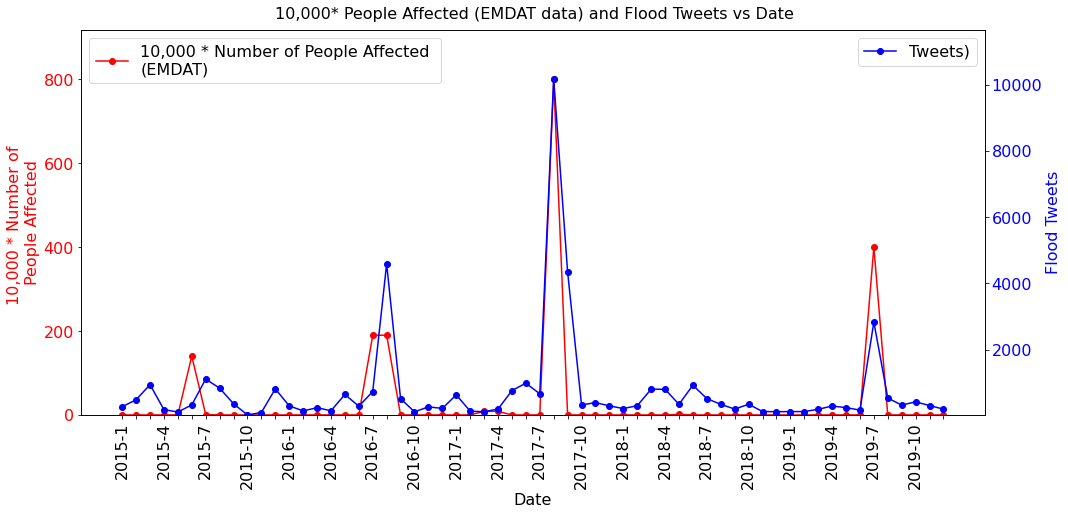

Spearmen Corr, pval: 0.2711, p-val=0.03616479917163872, n=60
Pearson Corr, pval: 0.8599, p-val=1.3901792583406901e-18, n=60


((0.2711, 0.03616479917163872, 60), (0.8599, 1.3901792583406901e-18, 60))

In [52]:
ignoreDates = {2020:[9,10,11,12]}
emdat_df = pd.read_csv('other_data/emdat_flood.csv').drop('Unnamed: 0', axis=1).fillna(0)
year_month = []
for row in emdat_df.iterrows():
    if int(row[1]['Start Month']):
        year_month.append(('{}-{}'.format(int(row[1]['Start Year']), int(row[1]['Start Month'])), 
                           row[1]['Total Affected']/10000))
    if int(row[1]['End Month']):
        year_month.append(('{}-{}'.format(int(row[1]['End Year']), int(row[1]['End Month'])), 
                        row[1]['Total Affected']/10000))
twitter_filepath = 'timeseries_data/twitter/TwitterAll.json'
twitterData = json.load(open(twitter_filepath))
twitterDataList = complete_day([(k,v) for k,v in twitterData.items()], aggType='month', 
                               year_range=[2015,2019], ignoreDates=ignoreDates)
twitterDataList, year_month = match_years_months(twitterDataList, year_month, [2015,2019])
plot_2timeseries(
            {'count_list': year_month, 'label':'10,000 * Number of People Affected \n(EMDAT)', 
             'color':'r', 'ylabel':'10,000 * Number of \nPeople Affected'},
            {'count_list': twitterDataList, 'label':'Tweets)', 
             'color':'b', 'ylabel':'Flood Tweets'},
            '10,000* People Affected (EMDAT data) and Flood Tweets vs Date', 'Date', True, skip=3)

ccf(twitterDataList, year_month, tupList=True, plot=True,
    title='Rajshahi PMW (max over month) and Normed Flood articles (yearly)', lag_max=40)

### Twitter, Satellite, News Media

In [121]:
def tsn(division='all', aggType='month', 
        normAgg='year', normDict=None, ignoreDates={2020:[9,10,11,12]}, plot=True, 
        yline=0.001, save_root=None):
    print('Division: {}'.format(division))
    dc = {}
    division = division.capitalize()
    result[division] = {}
    if not normDict: normDict = dateCounts
    
    twitter_filepath = 'timeseries_data/twitter/Twitter{}.json'.format(division)
    twitterData = json.load(open(twitter_filepath))
    twitterDataList2015 = complete_day([(k,v) for k,v in twitterData.items()], aggType=aggType, 
                                   year_range=[2015, 2020], ignoreDates=ignoreDates)
    twitterDataList2017 = complete_day([(k,v) for k,v in twitterData.items()], aggType=aggType, 
                                   year_range=[2017, 2020], ignoreDates=ignoreDates)
    
    if division=='All':
        article_filepath = 'timeseries_data/yearPublished_day/yearPublished_day.json'
    else:
        article_filepath = 'timeseries_data/yearPublished_day/yearPublished_day_{}.json'.format(division.lower())
    articleDates = json.load(open(article_filepath))
    aggDay2015 = complete_day([(k,v) for k,v in articleDates.items()], year_range=[2015, 2020],
                          aggType=aggType, normDict=normDict, normAgg=normAgg, ignoreDates=ignoreDates)
    aggDay2017 = complete_day([(k,v) for k,v in articleDates.items()], year_range=[2017, 2020],
                          aggType=aggType, normDict=normDict, normAgg=normAgg, ignoreDates=ignoreDates)
    
    aggSentinel2017 = get_Sentinel1_data_monthly('{}'.format(division.lower()), ignoreDates=ignoreDates)
    
    title = '' if division=='All' else division+': '
    if plot:
        save_path = os.path.join(save_root, '{}_news_twitter.pdf'.format(division.lower())) if save_root else None
        plot_2timeseries(
                {'count_list': twitterDataList2015, 'label':'Tweets)', 
                 'color':'r', 'ylabel':'Twitter'},
                {'count_list': aggDay2015, 'label':'News Media', 
                 'color': 'b', 'ylabel': 'Flood Articles %'},
                '', 'Date', True, skip=12, save_path=save_path, year_range=[2015,2020])
    n1, n2 = ccf(aggDay2015, twitterDataList2015, tupList=True, plot=True,
            title='Twitter Data and \n Normalized Flood articles (yearly)', lag_max=50)
    result[division]['news-twitter'] = { 'spearmen': n1, 'pearson': n2 }
    dc['news-twitter'] = { 'spearmen': n1, 'pearson': n2 }

    if plot: 
        save_path = os.path.join(save_root, '{}_news_sentinel1.pdf'.format(division.lower())) if save_root else None
        plot_2timeseries(
                {'count_list': aggSentinel2017, 'label':'Satellite', 
                 'color': 'black', 'ylabel': 'Flood area (km^2)'},
                {'count_list': aggDay2017, 'label':'News Media', 
                 'color': 'b', 'ylabel': 'Flood Articles %'},
                '', 'Date', True, skip=12, save_path=save_path, year_range=[2017,2020])
    n1, n2 = ccf(aggDay2017, aggSentinel2017, tupList=True, plot=True,
            title='Sentinel1 (Max over month) and \n Normalized Flood articles (yearly)', lag_max=50)
    result[division]['news-sentinel'] = { 'spearmen': n1, 'pearson': n2 }
    dc['news-sentinel'] = { 'spearmen': n1, 'pearson': n2 }
    
    if plot: 
        save_path = os.path.join(save_root, '{}_twitter_sentinel1.pdf'.format(division.lower())) if save_root else None
        plot_2timeseries(
                {'count_list': aggSentinel2017, 'label':'Satellite', 
                 'color': 'black', 'ylabel': 'Flood area (km^2)'},
                {'count_list': twitterDataList2017, 'label':'Tweets)', 
                 'color':'r', 'ylabel':'Twitter'},
                '', 'Date', True, skip=12, save_path=save_path, year_range=[2017,2020])
    n1, n2 = ccf(aggSentinel2017, twitterDataList2017, tupList=True, plot=True,
            title='Sentinel1 (Max over month) and \n Flood Tweets', lag_max=50)
    result[division]['twitter-sentinel'] = { 'spearmen': n1, 'pearson': n2 }
    dc['twitter-sentinel'] = { 'spearmen': n1, 'pearson': n2 }

In [114]:
def get_Sentinel1_data_monthly(division, agg_func=max, div_factor=1000000, ignoreDates={}):
    folderpath_s1 = 'other_data/Sentinel1_ts'
    files_s1 = [f for f in os.listdir(folderpath_s1) if '.csv' in f]
    s1_df = None
    if division == 'all':
        s1_df = pd.read_csv(os.path.join(folderpath_s1, 'Bangladesh-fulldata-2017-2020.csv'))
        s1_df_list = [(row[1]['Dates'], row[1]['country Flooded Area (m^2)']/div_factor) for row in s1_df.iterrows()]
    else:
        for filepath in files_s1:
            if division.lower() not in filepath.lower(): continue
            temp_df = pd.read_csv(os.path.join(folderpath_s1, filepath))
            if s1_df is None: s1_df = temp_df
            else: s1_df = pd.concat([s1_df,temp_df])
        s1_df_list = [(row[1]['Dates'], row[1]['division Flooded Area (m^2)']/div_factor) for row in s1_df.iterrows()]
    s1_month_count_list = aggregate_data_month(s1_df_list, aggregate_func=agg_func, ignoreDates=ignoreDates)
    return s1_month_count_list

In [119]:
def plot_2timeseries(l1, l2, title='', xlabel='', xticks_rotate=False, skip=0, plt_args={},
                     xticksFontSize=16, yticksFontSize=16, xLabelFontSize=16, ylabelFontSize=16, 
                     sameY=False, yline=None, save_path=None, year_range=[2017,2020]):
    xticksFontSize=plt_args.get('xticksFontSize',28)
    yticksFontSize=plt_args.get('yticksFontSize',28)
    xlabelFontSize=plt_args.get('xlabelFontSize',28)
    ylabelFontSize=plt_args.get('ylabelFontSize',28)
    titleFontSize=plt_args.get('titleFontSize',28)
    legendFontSize=plt_args.get('legendFontSize',28)
    figSize=plt_args.get('figSize',(15,7))
    
    plt.figure(figsize=figSize)

    # l1
    fig, ax1 = plt.subplots(figsize=figSize)
    plot_color = l1.get('color', 'r')
    if l1.get('type', None) == 'bar':
        ax1.bar([i[0] for i in l1['count_list']], [i[1] for i in l1['count_list']],
                color=plot_color, label=l1['label'])
    else:
        ax1.plot([i[0] for i in l1['count_list']], [i[1] for i in l1['count_list']],
                 linestyle='-', marker='x', color=plot_color, label=l1['label'], markersize=10)
    ax1.set_xlabel(xlabel, fontsize=xlabelFontSize)
    ax1.set_ylabel(l1.get('ylabel', ''), color=plot_color, fontsize=ylabelFontSize)
    ax1.tick_params(axis='y', labelcolor=plot_color, labelsize=yticksFontSize)
    ax1.tick_params(axis='x', labelrotation=90 if xticks_rotate else None, labelsize=xticksFontSize)
    ax1.legend(fontsize=legendFontSize, loc='upper left')
    x1minVal, x1maxVal = calculate_ylim([i[1] for i in l1['count_list']])
    ylim_min, ylim_max = l1.get('ylim_min', x1minVal), l1.get('ylim_max', x1maxVal)
    ax1.set_ylim(ylim_min, ylim_max)

    # l2
    ax2 = ax1.twinx()
    plot_color = l2.get('color', 'b')
    if l2.get('type', None) == 'bar':
        ax2.bar([i[0] for i in l2['count_list']], [i[1] for i in l2['count_list']],
                color=plot_color, label=l1['label'])
    else:
        ax2.plot([i[0] for i in l2['count_list']], [i[1] for i in l2['count_list']],
                 linestyle='-', marker='o', color=plot_color, label=l2['label'])
    ax2.set_xlabel(xlabel, fontsize=xlabelFontSize)
    ax2.set_ylabel(l2.get('ylabel', ''), color=plot_color, fontsize=ylabelFontSize)
    ax2.tick_params(axis='y', labelcolor=plot_color, labelsize=yticksFontSize)
    ax2.tick_params(axis='x', labelrotation=90 if xticks_rotate else None, labelsize=xticksFontSize)
    ax2.legend(fontsize=legendFontSize, loc='upper right')
    x2minVal, x2maxVal = calculate_ylim([i[1] for i in l2['count_list']])
    ylim_min, ylim_max = l1.get('ylim_min', x2minVal), l1.get('ylim_max', x2maxVal)
    ax2.set_ylim(ylim_min, ylim_max)
    
    if sameY:
        minVal, maxVal = min(x1minVal, x2minVal), max(x1maxVal,x2maxVal)
        ax1.set_ylim(minVal, maxVal)
        ax2.set_yticks([])
#         ax2.set_ylim(minVal, maxVal)
            

    plt.xticks([i[0] for i in l2['count_list']])
    

    fig.suptitle(title, fontsize=titleFontSize, y=title.count('\n') * .05 + 1.02)
    #     if xticks_rotate: fig.xticks(rotation='vertical')
    if skip:
        temp = ax1.xaxis.get_ticklabels()
        temp = list(set(temp) - set(temp[::skip]))
        for label in temp:
            label.set_visible(False)
    
    xt = []
    for i in range(year_range[0],year_range[1]+1): xt.extend([str(i)]*12)
    ax1.set_xticklabels(xt)
    
    if yline:
        plt.axhline(yline)
        plt.text(len(l1['count_list'])-0.75, yline+(yline/16), '{}'.format(yline) )
    fig.tight_layout()
    if save_path: plt.savefig(save_path, dpi=128)
    plt.show()

Division: sylhet


<Figure size 1080x504 with 0 Axes>

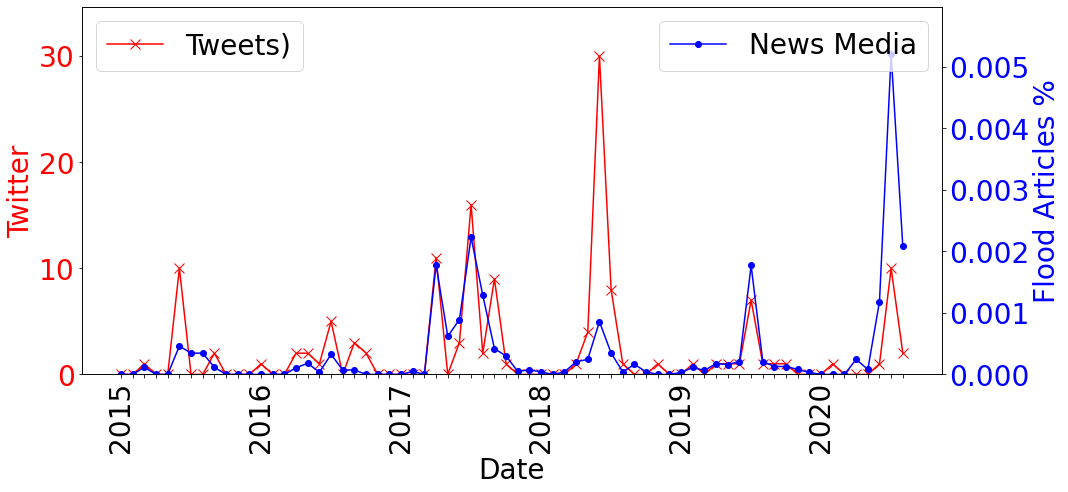

Spearmen Corr, pval: 0.6563, p-val=1.2357582849346993e-09, n=68
Pearson Corr, pval: 0.5005, p-val=1.3843954233701668e-05, n=68


<Figure size 1080x504 with 0 Axes>

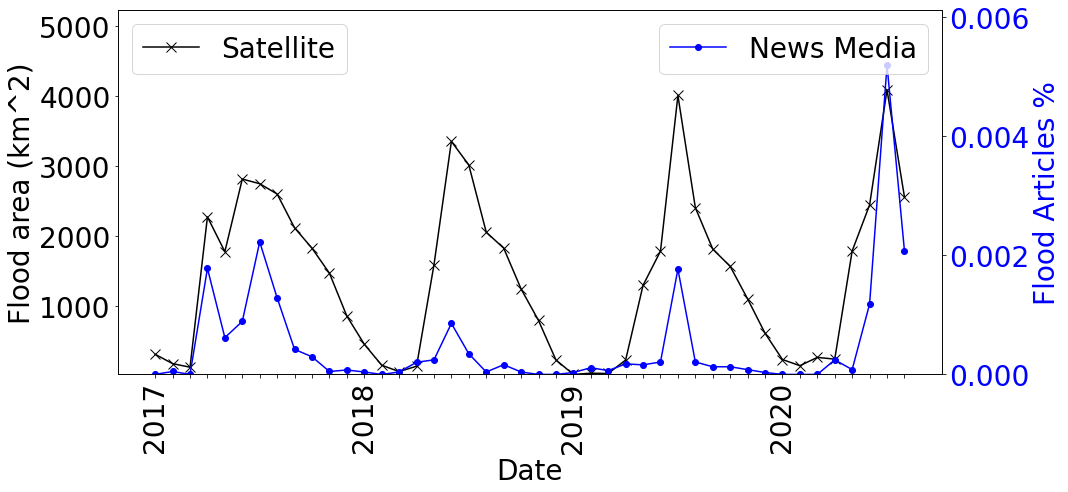

Spearmen Corr, pval: 0.7646, p-val=1.5324548415898584e-09, n=44
Pearson Corr, pval: 0.6913, p-val=2.0474125734287735e-07, n=44


<Figure size 1080x504 with 0 Axes>

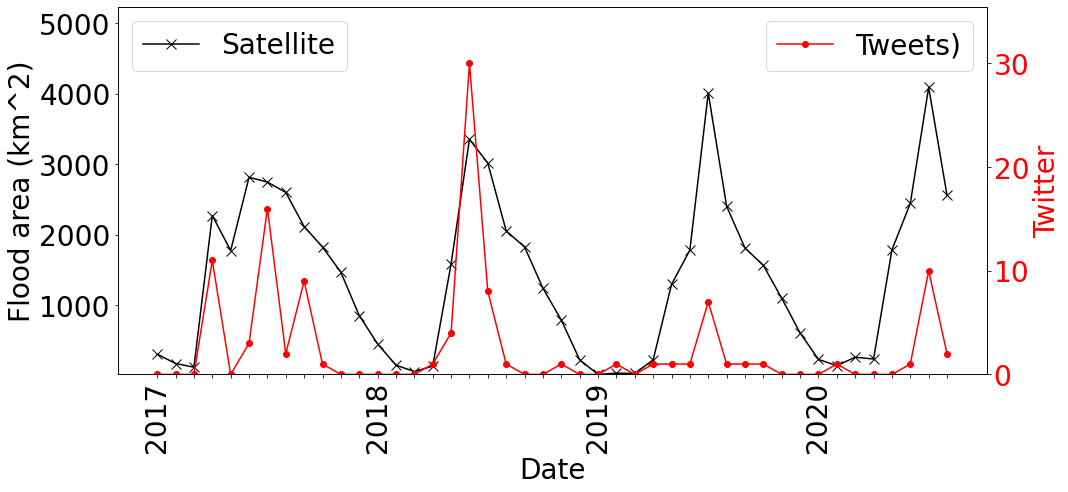

Spearmen Corr, pval: 0.6936, p-val=1.7906373958684131e-07, n=44
Pearson Corr, pval: 0.5995, p-val=1.706995317176447e-05, n=44
Division: rajshahi


<Figure size 1080x504 with 0 Axes>

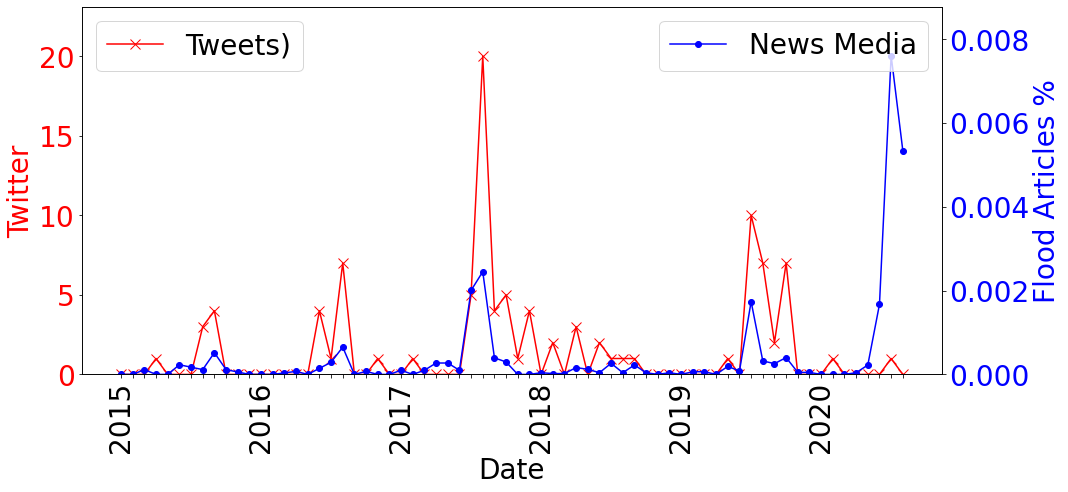

Spearmen Corr, pval: 0.429, p-val=0.0002620762173716246, n=68
Pearson Corr, pval: 0.2478, p-val=0.04163459970172368, n=68


<Figure size 1080x504 with 0 Axes>

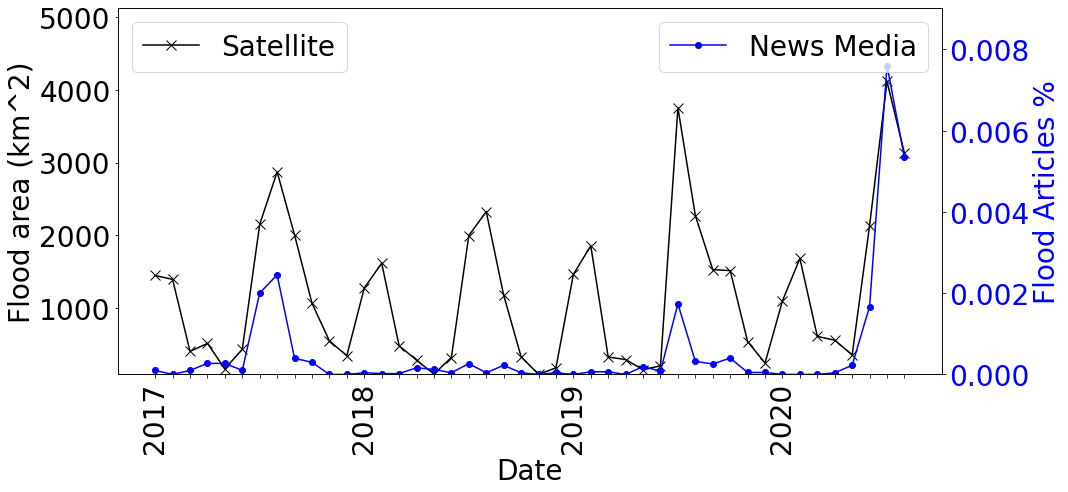

Spearmen Corr, pval: 0.4137, p-val=0.005244936966431269, n=44
Pearson Corr, pval: 0.7083, p-val=7.530907380896761e-08, n=44


<Figure size 1080x504 with 0 Axes>

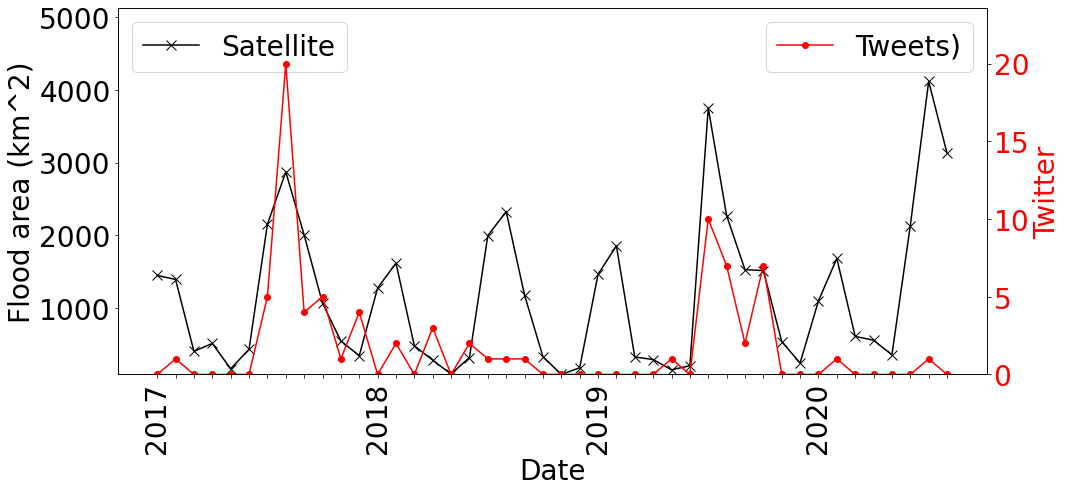

Spearmen Corr, pval: 0.4584, p-val=0.0017538602738872953, n=44
Pearson Corr, pval: 0.4753, p-val=0.0011132803590003, n=44
Division: dhaka


<Figure size 1080x504 with 0 Axes>

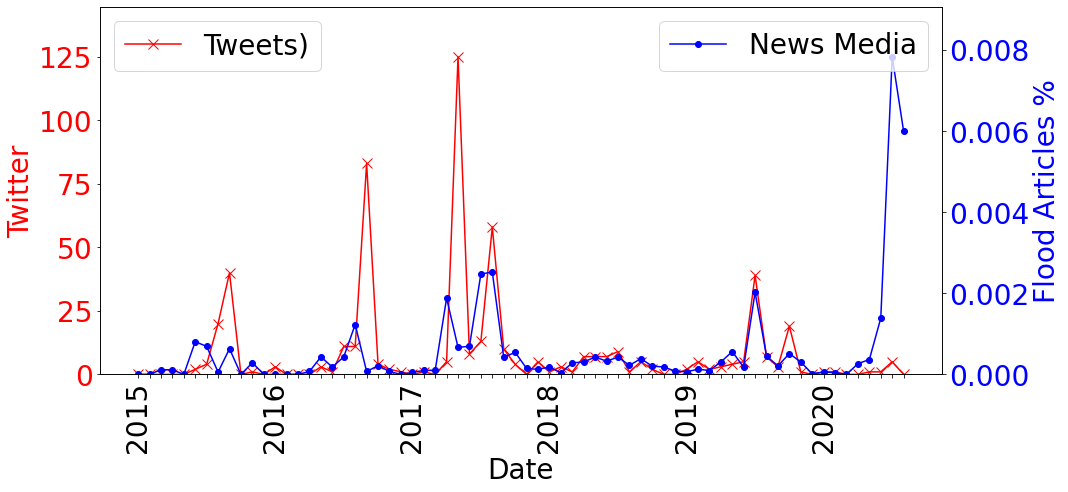

Spearmen Corr, pval: 0.6076, p-val=3.9289037771024304e-08, n=68
Pearson Corr, pval: 0.1061, p-val=0.38900606700431517, n=68


<Figure size 1080x504 with 0 Axes>

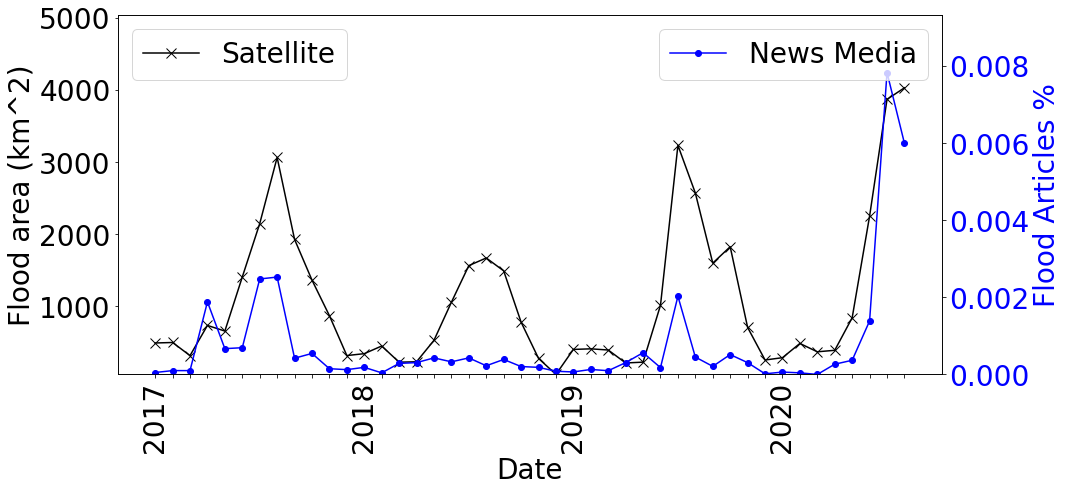

Spearmen Corr, pval: 0.6525, p-val=1.5893434413436664e-06, n=44
Pearson Corr, pval: 0.7808, p-val=4.058181166384434e-10, n=44


<Figure size 1080x504 with 0 Axes>

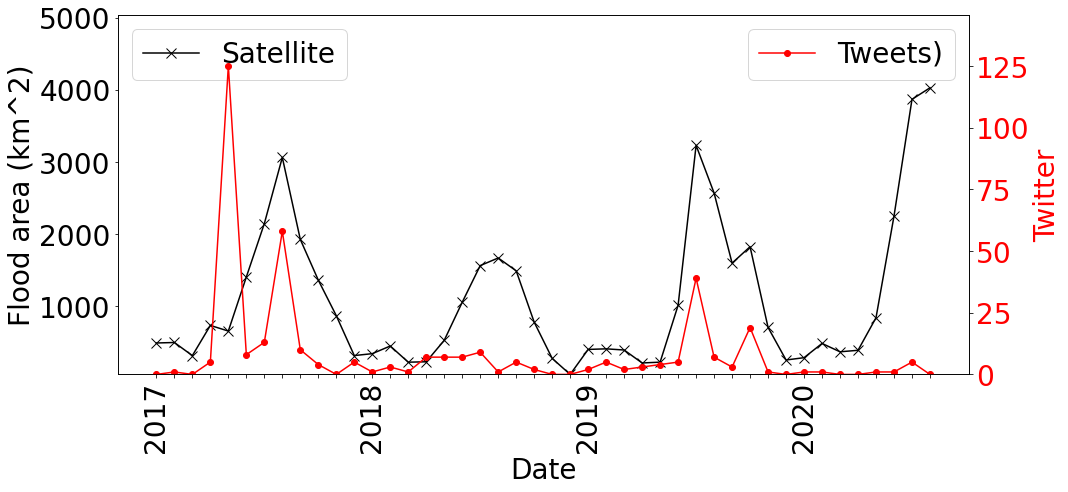

Spearmen Corr, pval: 0.4656, p-val=0.0014482215632086609, n=44
Pearson Corr, pval: 0.2011, p-val=0.19044718927403875, n=44
Division: barishal


<Figure size 1080x504 with 0 Axes>

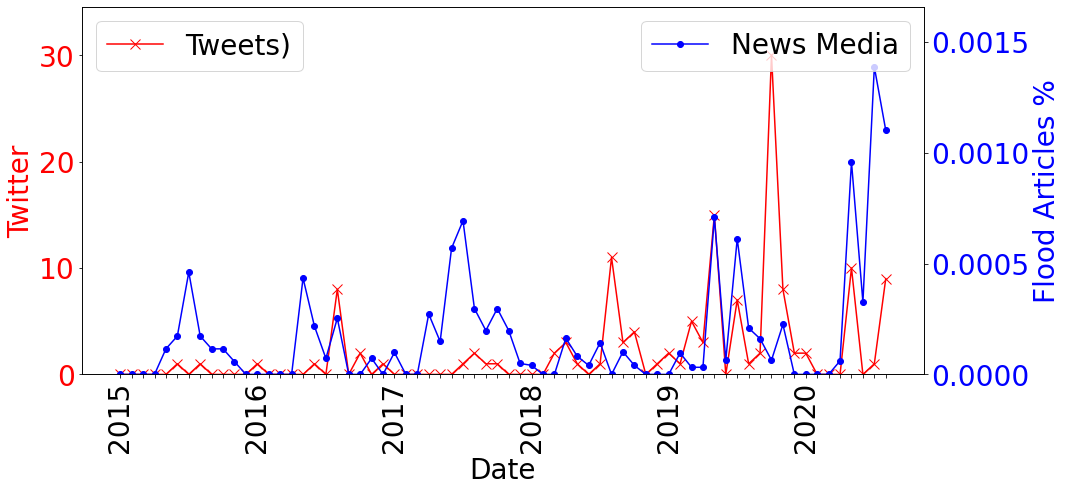

Spearmen Corr, pval: 0.2649, p-val=0.029053435984614955, n=68
Pearson Corr, pval: 0.251, p-val=0.038928455185197004, n=68


<Figure size 1080x504 with 0 Axes>

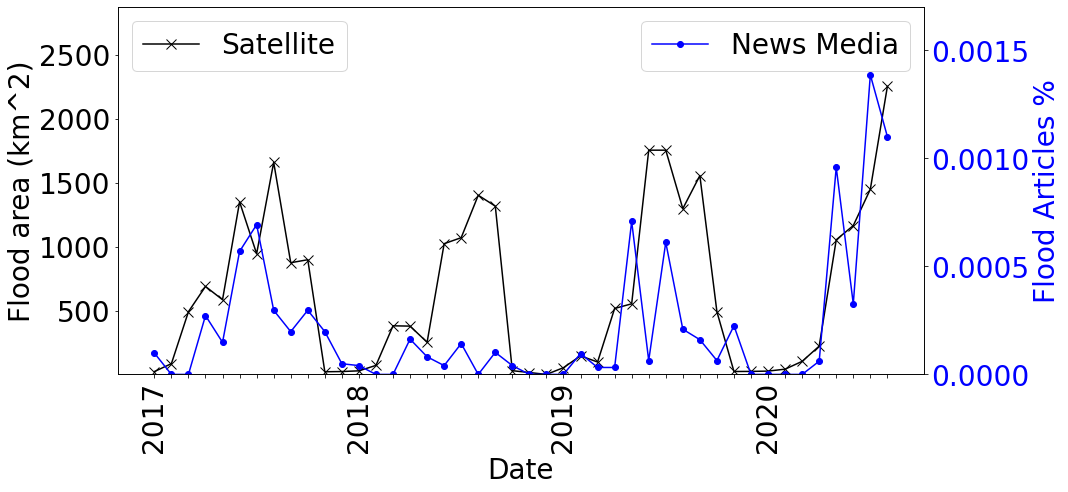

Spearmen Corr, pval: 0.5861, p-val=2.915537466870071e-05, n=44
Pearson Corr, pval: 0.5831, p-val=3.269618175012974e-05, n=44


<Figure size 1080x504 with 0 Axes>

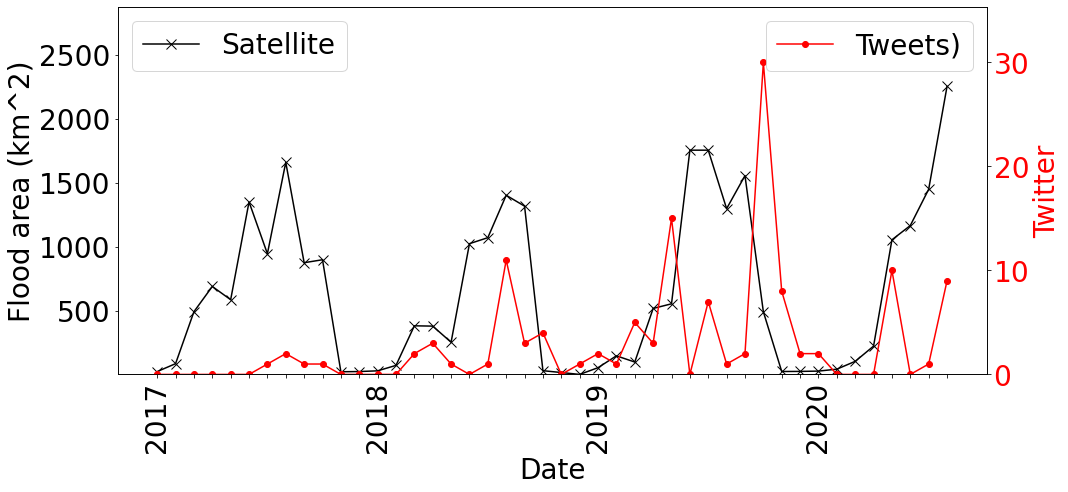

Spearmen Corr, pval: 0.2406, p-val=0.11573731701262405, n=44
Pearson Corr, pval: 0.1405, p-val=0.3630193297862663, n=44
Division: chattogram


<Figure size 1080x504 with 0 Axes>

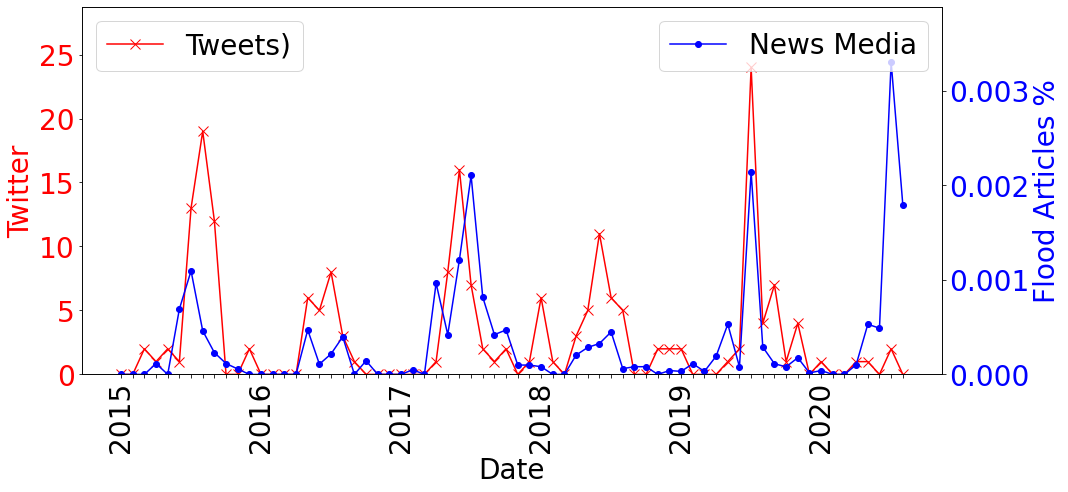

Spearmen Corr, pval: 0.5284, p-val=3.63346682443274e-06, n=68
Pearson Corr, pval: 0.4161, p-val=0.00041678906975173535, n=68


<Figure size 1080x504 with 0 Axes>

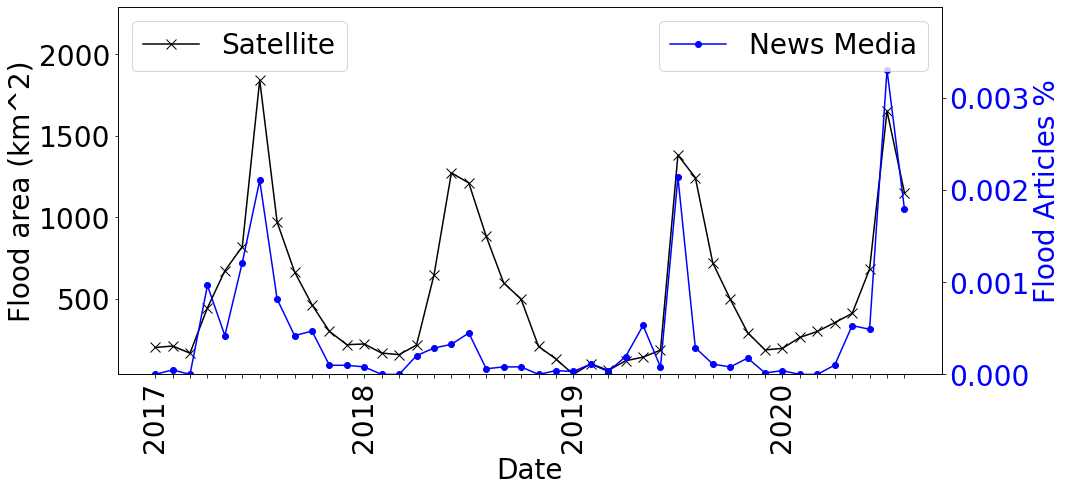

Spearmen Corr, pval: 0.6696, p-val=6.68236239121372e-07, n=44
Pearson Corr, pval: 0.7657, p-val=1.3988559901263181e-09, n=44


<Figure size 1080x504 with 0 Axes>

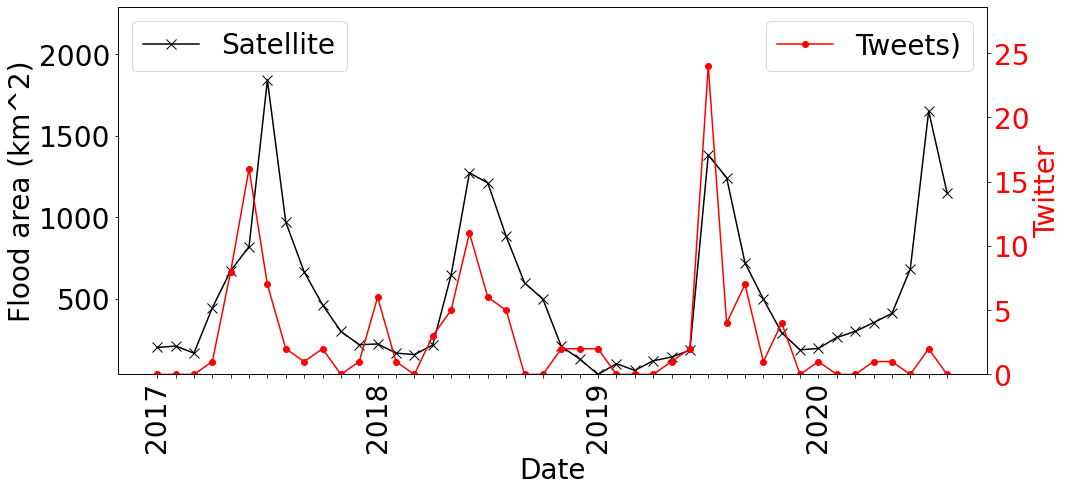

Spearmen Corr, pval: 0.5095, p-val=0.00041165822425303435, n=44
Pearson Corr, pval: 0.5377, p-val=0.00016718374606947893, n=44
Division: khulna


<Figure size 1080x504 with 0 Axes>

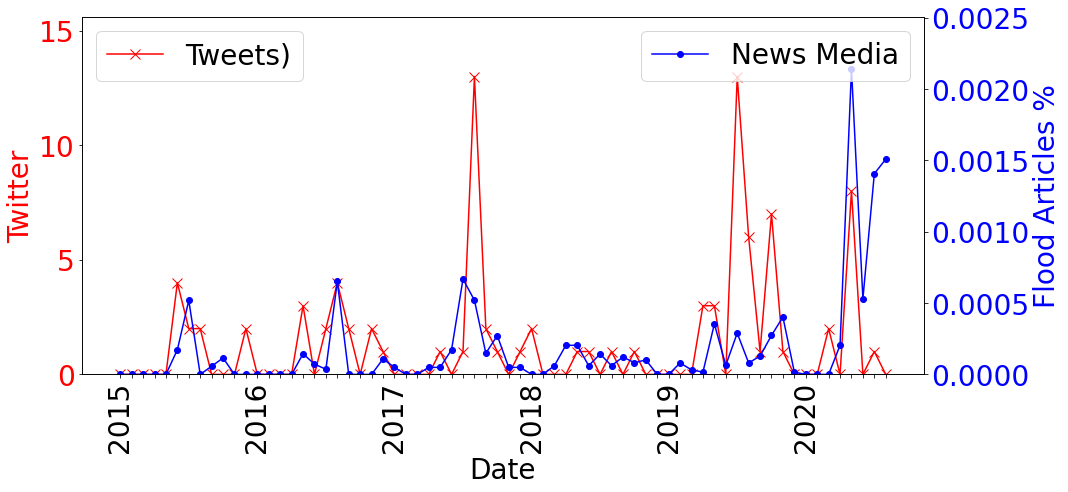

Spearmen Corr, pval: 0.3851, p-val=0.0011819670049458945, n=68
Pearson Corr, pval: 0.3462, p-val=0.003826215811860986, n=68


<Figure size 1080x504 with 0 Axes>

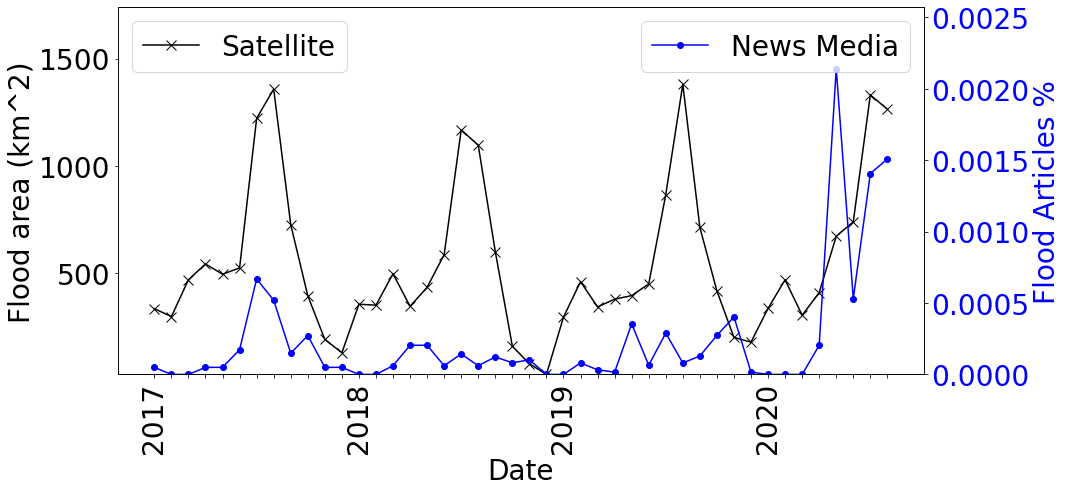

Spearmen Corr, pval: 0.5356, p-val=0.00017959716430596202, n=44
Pearson Corr, pval: 0.4825, p-val=0.0009101480380382889, n=44


<Figure size 1080x504 with 0 Axes>

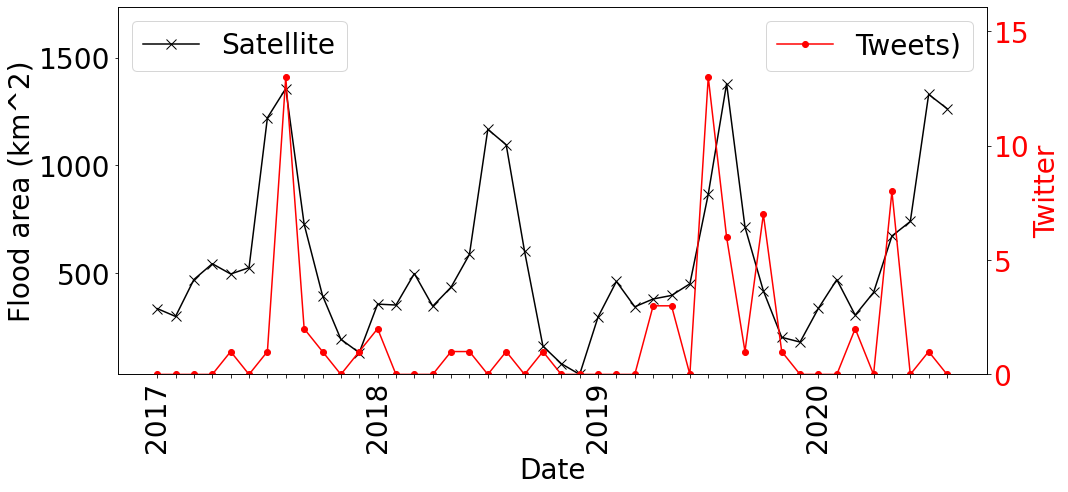

Spearmen Corr, pval: 0.2913, p-val=0.055030669349149096, n=44
Pearson Corr, pval: 0.3962, p-val=0.00776635919768557, n=44
Division: rangpur


<Figure size 1080x504 with 0 Axes>

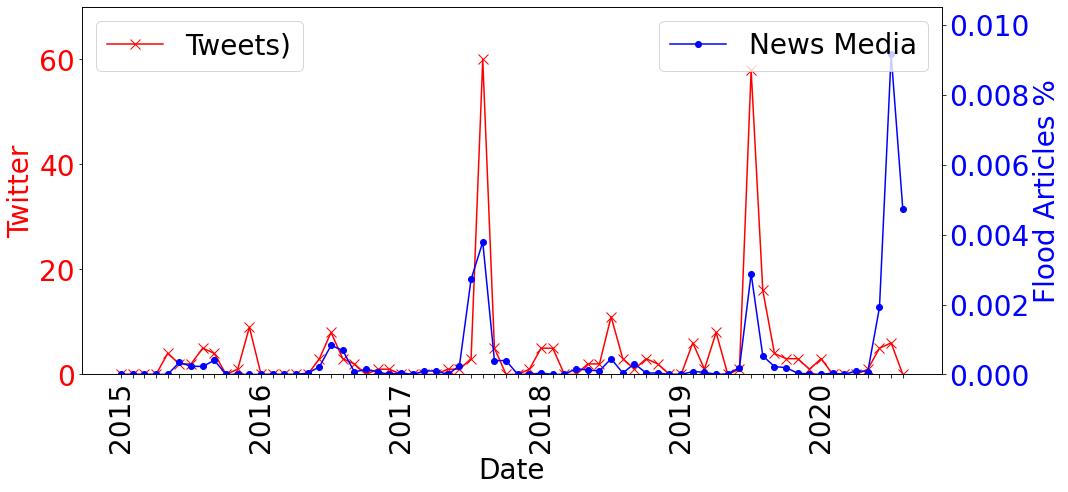

Spearmen Corr, pval: 0.4738, p-val=4.4734440346891636e-05, n=68
Pearson Corr, pval: 0.3986, p-val=0.0007611945037503755, n=68


<Figure size 1080x504 with 0 Axes>

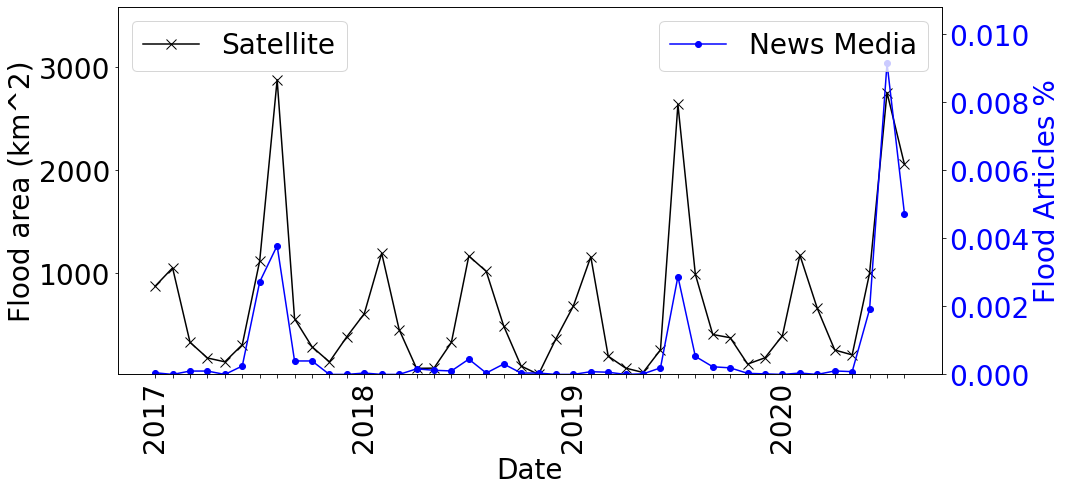

Spearmen Corr, pval: 0.3425, p-val=0.022853007653335478, n=44
Pearson Corr, pval: 0.7871, p-val=2.3566437192181055e-10, n=44


<Figure size 1080x504 with 0 Axes>

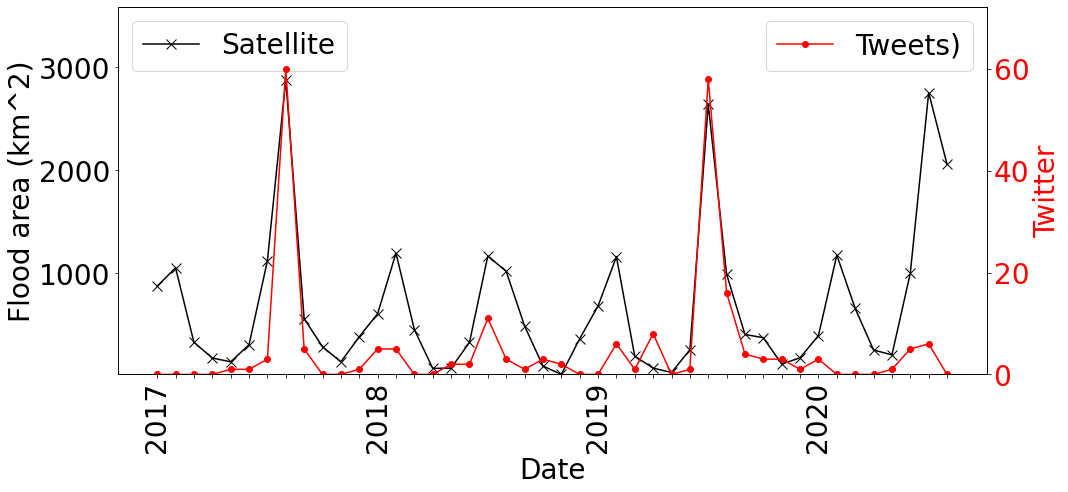

Spearmen Corr, pval: 0.3353, p-val=0.026088244442473093, n=44
Pearson Corr, pval: 0.6825, p-val=3.346417577397252e-07, n=44
Division: mymensingh


<Figure size 1080x504 with 0 Axes>

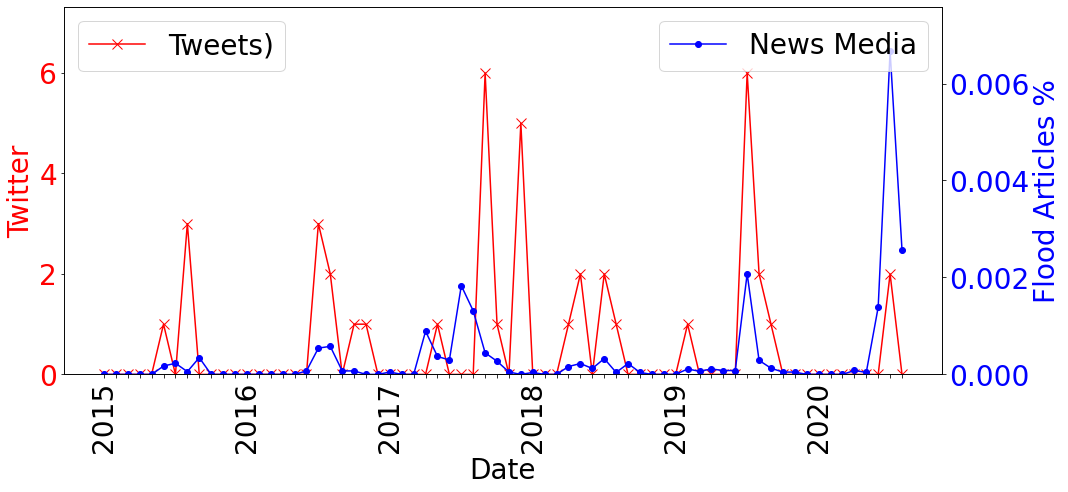

Spearmen Corr, pval: 0.4448, p-val=0.00014434659973460408, n=68
Pearson Corr, pval: 0.2485, p-val=0.04099445600502233, n=68


<Figure size 1080x504 with 0 Axes>

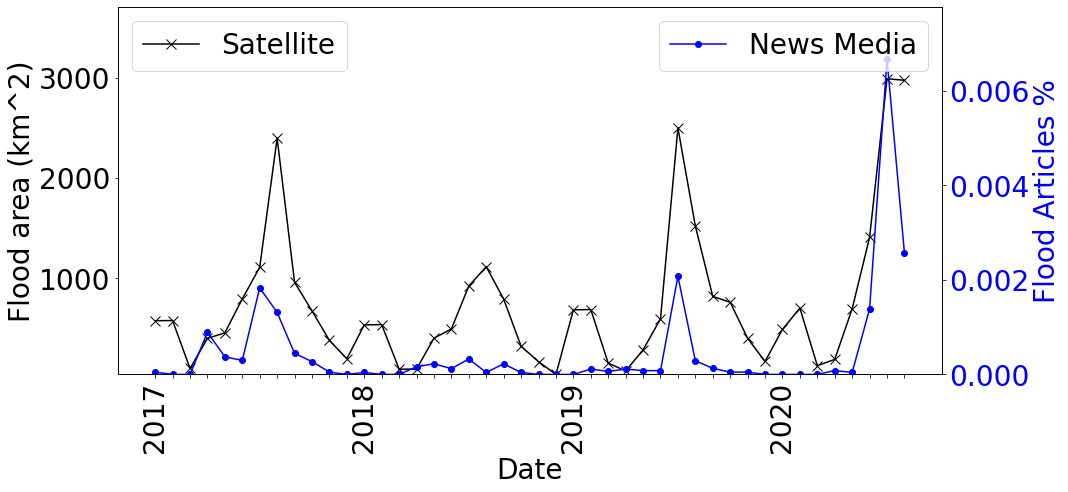

Spearmen Corr, pval: 0.5924, p-val=2.2676581201421515e-05, n=44
Pearson Corr, pval: 0.7896, p-val=1.8920297767077178e-10, n=44


<Figure size 1080x504 with 0 Axes>

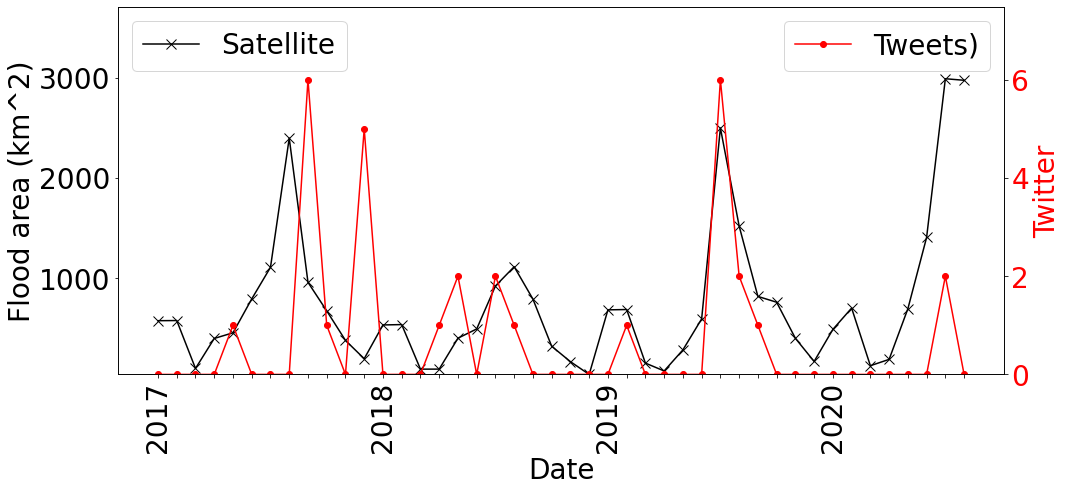

Spearmen Corr, pval: 0.3381, p-val=0.024775186384837375, n=44
Pearson Corr, pval: 0.3078, p-val=0.0421058935081293, n=44
Division: all


<Figure size 1080x504 with 0 Axes>

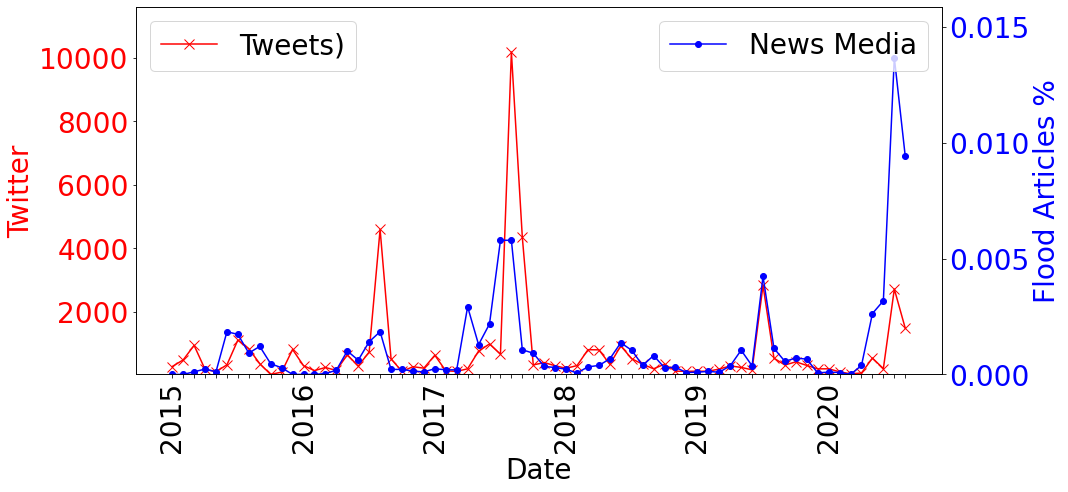

Spearmen Corr, pval: 0.5712, p-val=3.640994995919603e-07, n=68
Pearson Corr, pval: 0.4667, p-val=6.021506871714784e-05, n=68


<Figure size 1080x504 with 0 Axes>

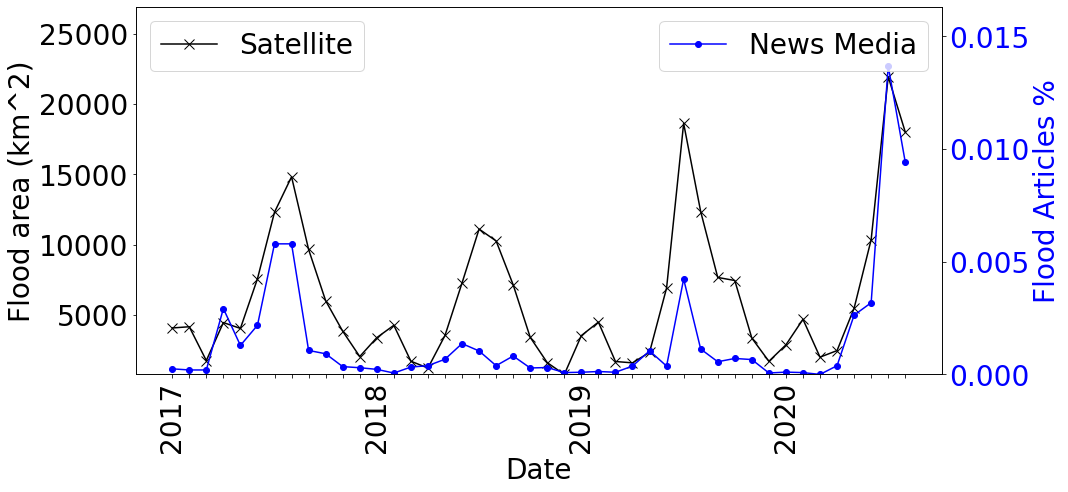

Spearmen Corr, pval: 0.696, p-val=1.5643603817293738e-07, n=44
Pearson Corr, pval: 0.8215, p-val=8.389908518171541e-12, n=44


<Figure size 1080x504 with 0 Axes>

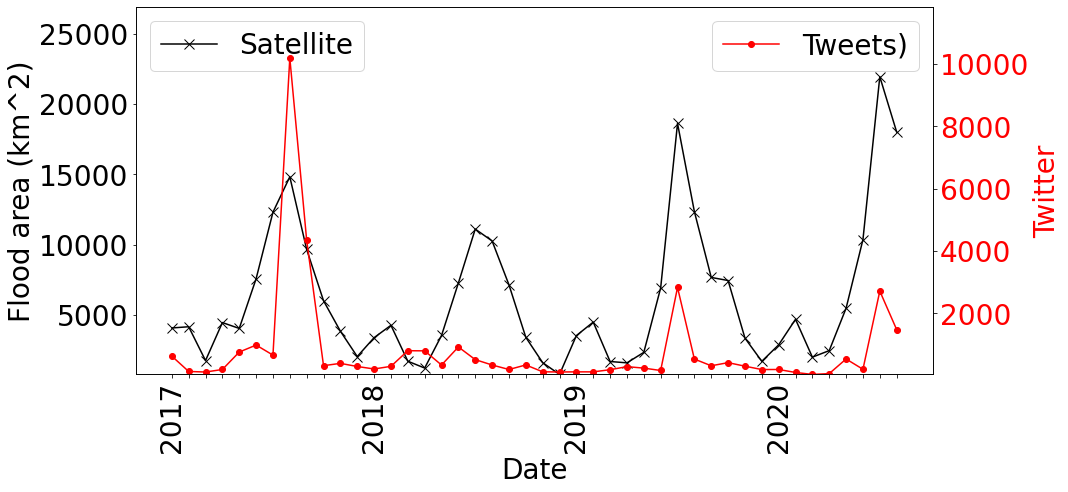

Spearmen Corr, pval: 0.5518, p-val=0.00010347838819649685, n=44
Pearson Corr, pval: 0.5297, p-val=0.00021794137155776804, n=44


In [122]:
result = {}
save_root = '/Users/tejitpabari/Desktop/BangladeshFloodResearch/nlp_flood_research/classifier/images/cross_corr'
plot=True
tsn('sylhet', plot=plot, save_root=save_root)
tsn('rajshahi', plot=plot, save_root=save_root)
tsn('dhaka', plot=plot, save_root=save_root)
tsn('barishal', plot=plot, save_root=save_root)
tsn('chattogram', plot=plot, save_root=save_root)
tsn('khulna', plot=plot, save_root=save_root)
tsn('rangpur', plot=plot, save_root=save_root)
tsn('mymensingh', plot=plot, save_root=save_root)
tsn('all', plot=plot, save_root=save_root)

In [92]:
result['All']

{'news-twitter': {'spearmen': (0.5712, 3.640994995919603e-07, 68),
  'pearson': (0.4667, 6.021506871714784e-05, 68)},
 'news-sentinel': {'spearmen': (0.696, 1.5643603817293738e-07, 44),
  'pearson': (0.8215, 8.389908518171541e-12, 44)},
 'twitter-sentinel': {'spearmen': (0.5518, 0.00010347838819649685, 44),
  'pearson': (0.5297, 0.00021794137155776804, 44)}}

In [127]:
pd.options.display.max_colwidth = 200
org_result = result.copy()
# if 'All' in result:
#     del result['All']
result2 = {k:
           {k2:', '.join(['{}'.format(v3[0]) 
                          for k3,v3 in v2.items()]) 
              for k2,v2 in v.items()} 
           for k,v in result.items()}
result3 = {k:
           {k2:'{}, {:.10f}'.format(v2['spearmen'][0], v2['spearmen'][1]) 
              for k2,v2 in v.items()}
           for k,v in result.items()}
result4 = {k:
           {k2:'{}, {:.8f}'.format(v2['pearson'][0], v2['pearson'][1]) 
              for k2,v2 in v.items()} 
           for k,v in result.items()}
# result = org_result
print(pd.DataFrame(result4).to_latex())

\begin{tabular}{llllllllll}
\toprule
{} &              Sylhet &            Rajshahi &               Dhaka &            Barishal &          Chattogram &              Khulna &             Rangpur &          Mymensingh &                 All \\
\midrule
news-twitter     &  0.5005, 0.00001384 &  0.2478, 0.04163460 &  0.1061, 0.38900607 &   0.251, 0.03892846 &  0.4161, 0.00041679 &  0.3462, 0.00382622 &  0.3986, 0.00076119 &  0.2485, 0.04099446 &  0.4667, 0.00006022 \\
news-sentinel    &  0.6913, 0.00000020 &  0.7083, 0.00000008 &  0.7808, 0.00000000 &  0.5831, 0.00003270 &  0.7657, 0.00000000 &  0.4825, 0.00091015 &  0.7871, 0.00000000 &  0.7896, 0.00000000 &  0.8215, 0.00000000 \\
twitter-sentinel &  0.5995, 0.00001707 &  0.4753, 0.00111328 &  0.2011, 0.19044719 &  0.1405, 0.36301933 &  0.5377, 0.00016718 &  0.3962, 0.00776636 &  0.6825, 0.00000033 &  0.3078, 0.04210589 &  0.5297, 0.00021794 \\
\bottomrule
\end{tabular}



In [126]:
pd.DataFrame(result3)

Sylhet              Rajshahi  \
news-twitter      0.6563, 0.0000000012   0.429, 0.0002620762   
news-sentinel     0.7646, 0.0000000015  0.4137, 0.0052449370   
twitter-sentinel  0.6936, 0.0000001791  0.4584, 0.0017538603   

                                 Dhaka              Barishal  \
news-twitter      0.6076, 0.0000000393  0.2649, 0.0290534360   
news-sentinel     0.6525, 0.0000015893  0.5861, 0.0000291554   
twitter-sentinel  0.4656, 0.0014482216  0.2406, 0.1157373170   

                            Chattogram                Khulna  \
news-twitter      0.5284, 0.0000036335  0.3851, 0.0011819670   
news-sentinel     0.6696, 0.0000006682  0.5356, 0.0001795972   
twitter-sentinel  0.5095, 0.0004116582  0.2913, 0.0550306693   

                               Rangpur            Mymensingh  \
news-twitter      0.4738, 0.0000447344  0.4448, 0.0001443466   
news-sentinel     0.3425, 0.0228530077  0.5924, 0.0000226766   
twitter-sentinel  0.3353, 0.0260882444  0.3381, 0.0247751864   

                                   All  
news-twitter      0.5712, 0.0000003641  
news-sentinel      0.696, 0.0000001564  
twitter-sentinel  0.5518, 0.0001034784

In [66]:
result3 = {k2:'{}'.format(v2['spearmen'][0]) 
              for k2,v2 in result['All'].items()}
result4 = {k2:'{}'.format(v2['pearson'][0]) 
              for k2,v2 in result['All'].items()} 
result3, result4

({'news-twitter': '0.5712',
  'news-sentinel': '0.696',
  'twitter-sentinel': '0.5518'},
 {'news-twitter': '0.4667',
  'news-sentinel': '0.8215',
  'twitter-sentinel': '0.5297'})

### Newspapers, monthly, norm=yearly

In [110]:
# newspaperDataFiles = {'bdnews':'timeseries_data/yearPublished_day_newspaper/bdnews.json',
#                  'dailyObserver': 'timeseries_data/yearPublished_day_newspaper/dailyObserver.json',
#                  'dailySun':'timeseries_data/yearPublished_day_newspaper/dailySun.json',
#                  'dhakaTribune':'timeseries_data/yearPublished_day_newspaper/dhakaTribune.json',
#                  'newAge':'timeseries_data/yearPublished_day_newspaper/newAge.json',
#                  'theIndependent':'timeseries_data/yearPublished_day_newspaper/theIndependent.json',
#                  'theDailyStar':'timeseries_data/yearPublished_day_newspaper/theDailyStar.json',
#                  'prothomalo': 'timeseries_data/yearPublished_day_newspaper/prothomalo.json'
#                 }
# newspaperIgnoreYears = { 'dailyObserver': [2019,2020]
#                 }

In [36]:
# def plot_newspaper_normalized(newspaper):
#     nData = json.load(open(newspaperDataFiles[newspaper]))
#     nNormData = paperCounts[newspaper]
#     ignoreDates = {2020:[8,9,10,11,12]}
#     aggDayPrev = complete_day([(k,v) for k,v in nData.items()], year_range=[2017,2020], 
#                           aggType='month', ignoreDates=ignoreDates)
#     aggDay = complete_day([(k,v) for k,v in nData.items()], year_range=[2017,2020], 
#                           aggType='month', normDict=nNormData, normAgg='year', ignoreDates=ignoreDates)
#     plt_args = {
#         'xticksFontSize': 20,
#         'yticksFontSize': 20,
#         'xlabelFontSize': 22,
#         'ylabelFontSize': 22,
#         'legendFontSize': 22,
#     }
#     plot_2timeseries(
#                 {'count_list': aggDayPrev, 'label':'flood articles', 
#                  'color':'r', 'ylabel':'# articles'},
#                 {'count_list': aggDay, 'label':'Normed flood articles', 
#                  'color': 'b', 'ylabel': '# articles / total'},
#                 '{} - Flood articles (aggregated monthly) and Normed Flood articles (yearly) vs Date'.format(newspaper),
#                 'Date', True, skip=2, plt_args=plt_args)

<Figure size 1080x504 with 0 Axes>

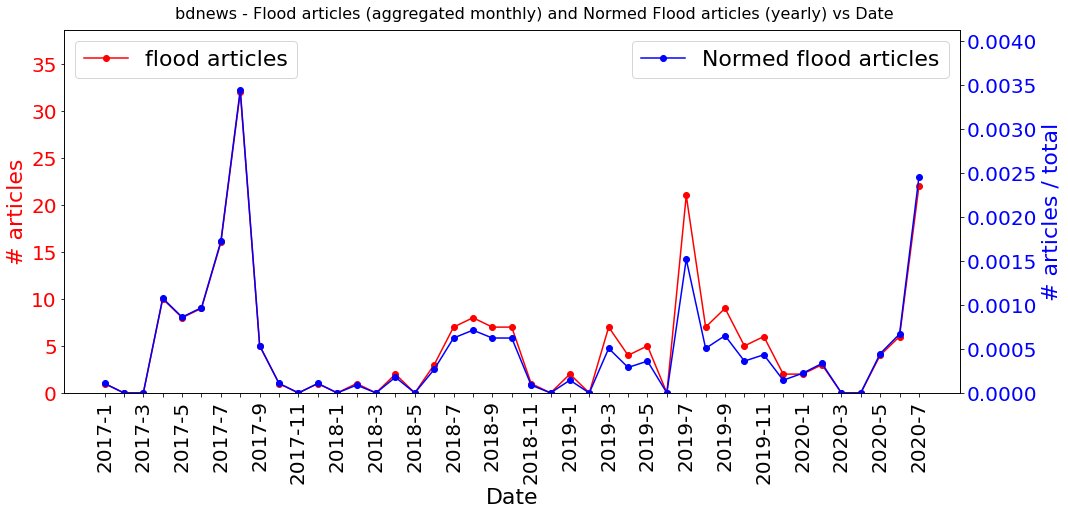

<Figure size 1080x504 with 0 Axes>

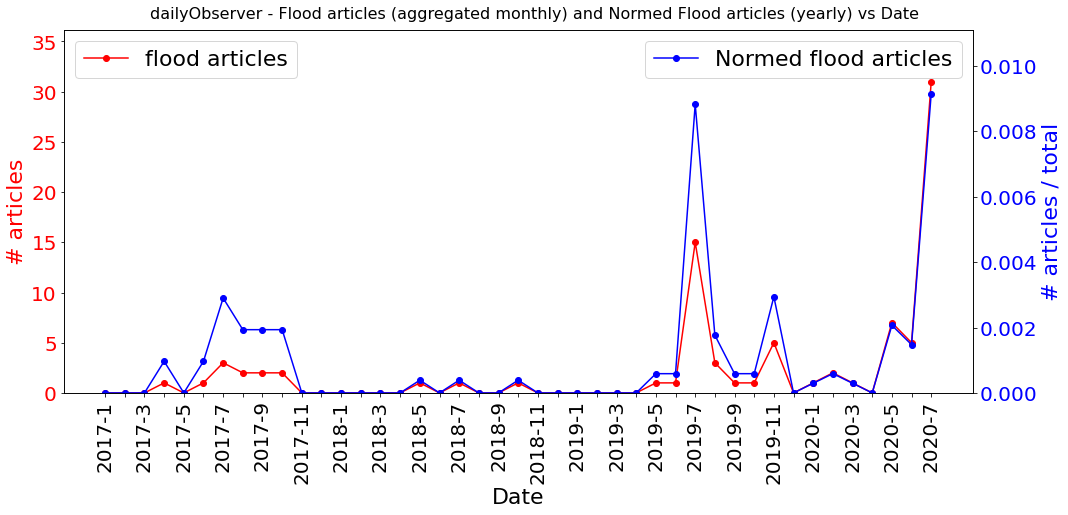

<Figure size 1080x504 with 0 Axes>

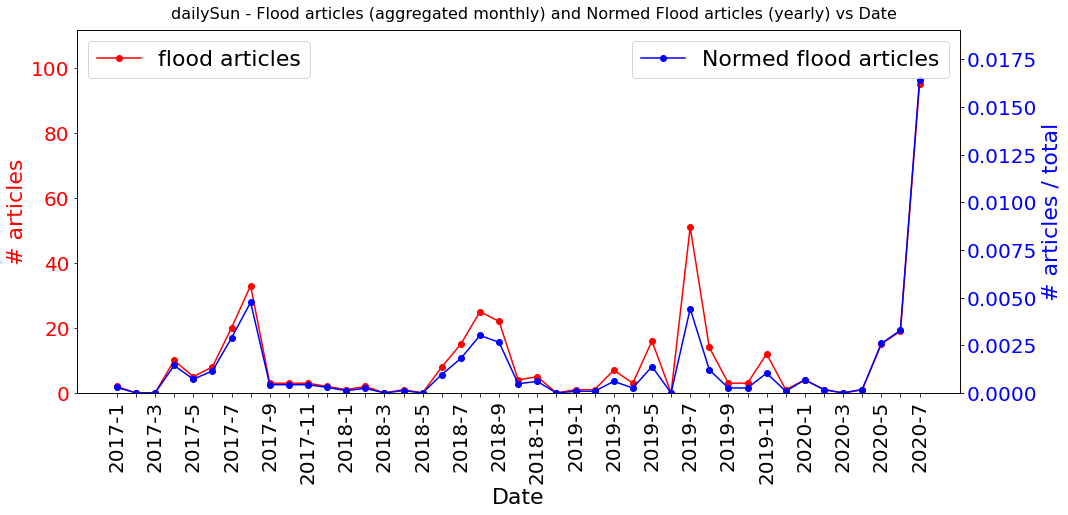

<Figure size 1080x504 with 0 Axes>

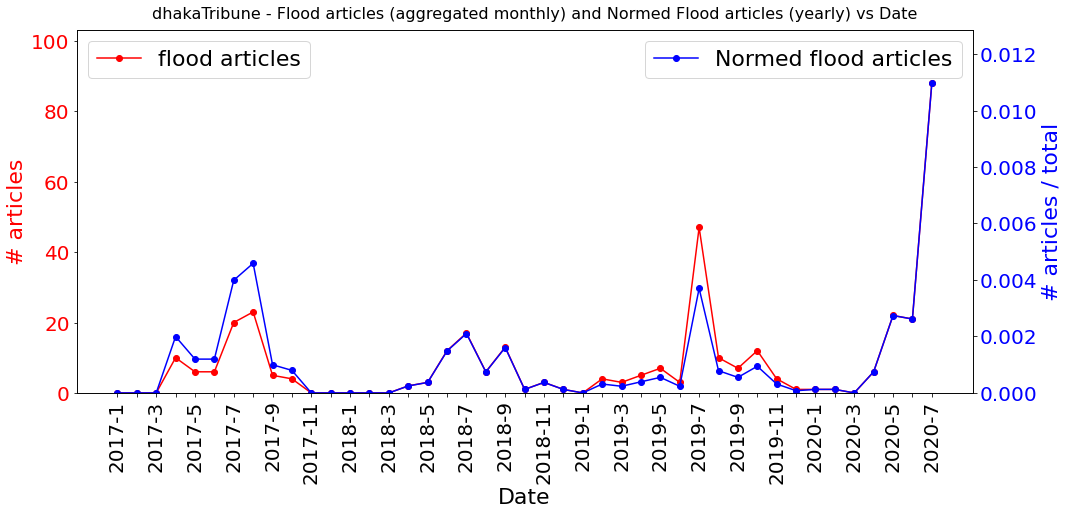

<Figure size 1080x504 with 0 Axes>

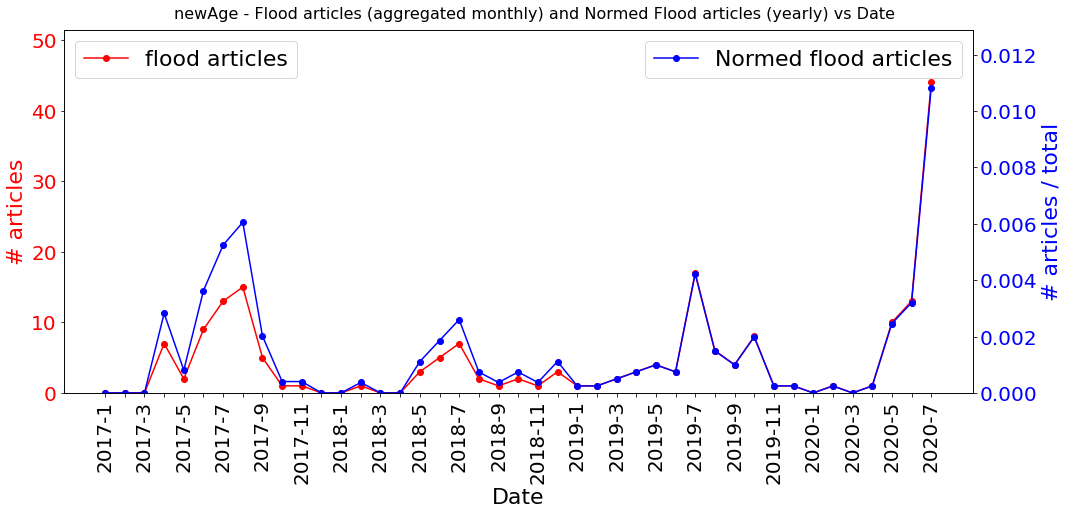

<Figure size 1080x504 with 0 Axes>

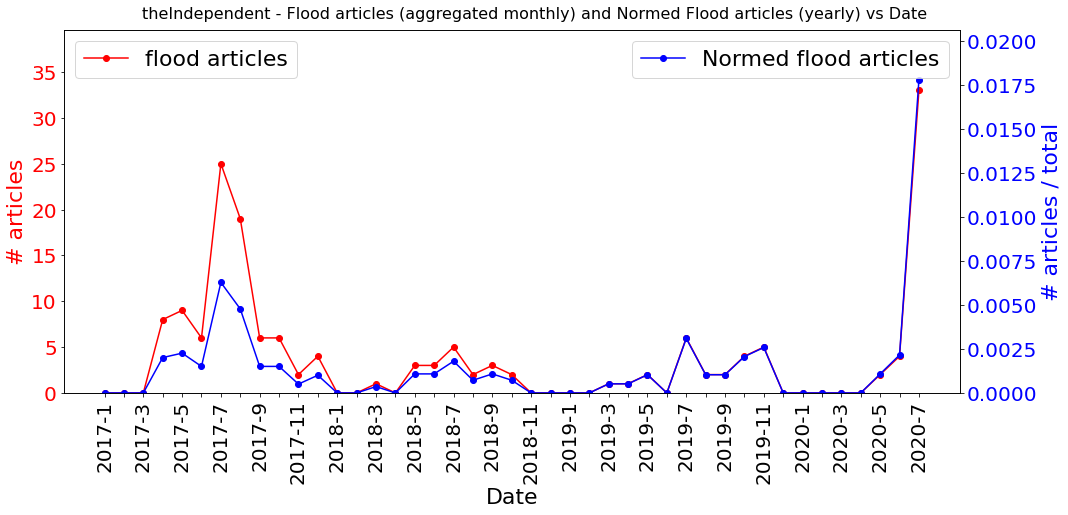

<Figure size 1080x504 with 0 Axes>

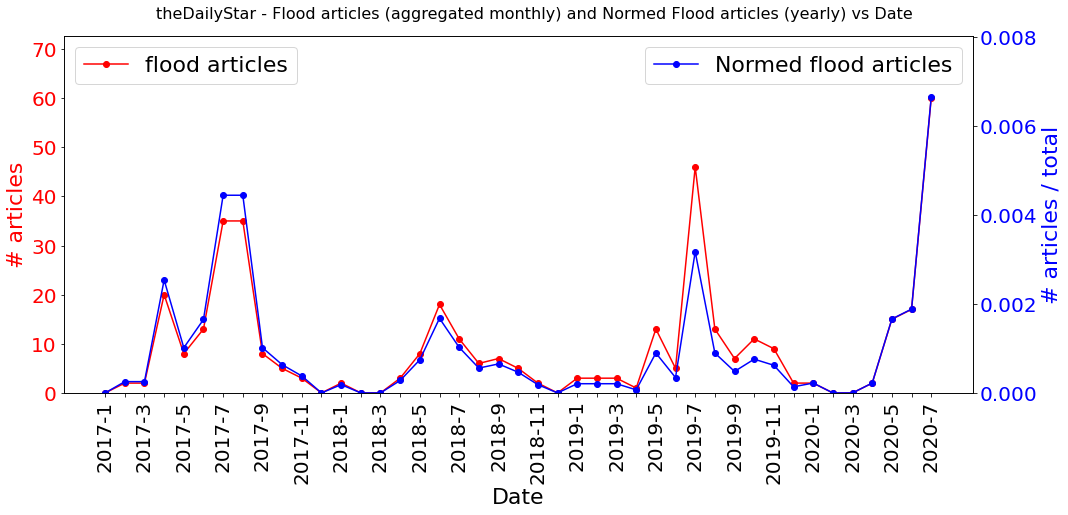

<Figure size 1080x504 with 0 Axes>

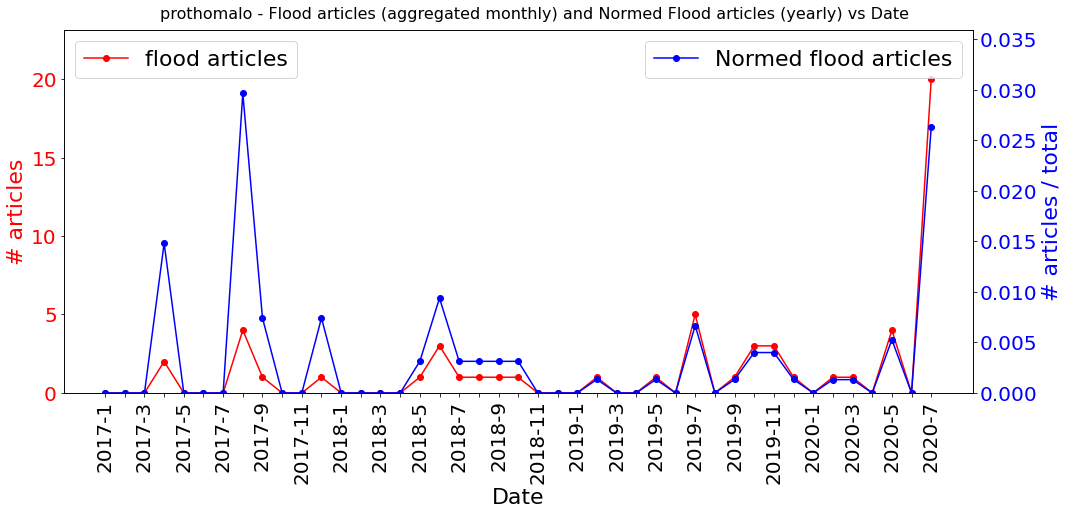

In [37]:
# for newspaper in newspaperDataFiles:
#     try:
#         plot_newspaper_normalized(newspaper)
#     except Exception as e:
#         print(e)
#         continue